In [ ]:
"""
Lab 5: Topic Modeling
Extract 15 documents from Wikipedia (5 per topic), preprocess, and create BoW & TF-IDF
"""

import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize
from datasets import load_dataset
import re

from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

In [ ]:
nltk.download('punkt_tab', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)

True

In [ ]:
dataset = load_dataset('squad', split='train')
squad_df = pd.DataFrame(dataset)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

plain_text/train-00000-of-00001.parquet:   0%|          | 0.00/14.5M [00:00<?, ?B/s]

plain_text/validation-00000-of-00001.par(…):   0%|          | 0.00/1.82M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/87599 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10570 [00:00<?, ? examples/s]

In [ ]:
squad_df

id                     title  \
0      5733be284776f41900661182  University_of_Notre_Dame   
1      5733be284776f4190066117f  University_of_Notre_Dame   
2      5733be284776f41900661180  University_of_Notre_Dame   
3      5733be284776f41900661181  University_of_Notre_Dame   
4      5733be284776f4190066117e  University_of_Notre_Dame   
...                         ...                       ...   
87594  5735d259012e2f140011a09d                 Kathmandu   
87595  5735d259012e2f140011a09e                 Kathmandu   
87596  5735d259012e2f140011a09f                 Kathmandu   
87597  5735d259012e2f140011a0a0                 Kathmandu   
87598  5735d259012e2f140011a0a1                 Kathmandu   

                                                 context  \
0      Architecturally, the school has a Catholic cha...   
1      Architecturally, the school has a Catholic cha...   
2      Architecturally, the school has a Catholic cha...   
3      Architecturally, the school has a Catholic cha...   
4      Architecturally, the school has a Catholic cha...   
...                                                  ...   
87594  Kathmandu Metropolitan City (KMC), in order to...   
87595  Kathmandu Metropolitan City (KMC), in order to...   
87596  Kathmandu Metropolitan City (KMC), in order to...   
87597  Kathmandu Metropolitan City (KMC), in order to...   
87598  Kathmandu Metropolitan City (KMC), in order to...   

                                                question  \
0      To whom did the Virgin Mary allegedly appear i...   
1      What is in front of the Notre Dame Main Building?   
2      The Basilica of the Sacred heart at Notre Dame...   
3                      What is the Grotto at Notre Dame?   
4      What sits on top of the Main Building at Notre...   
...                                                  ...   
87594  In what US state did Kathmandu first establish...   
87595               What was Yangon previously known as?   
87596  With what Belorussian city does Kathmandu have...   
87597  In what year did Kathmandu create its initial ...   
87598                      What is KMC an initialism of?   

                                                 answers  
0      {'text': ['Saint Bernadette Soubirous'], 'answ...  
1      {'text': ['a copper statue of Christ'], 'answe...  
2      {'text': ['the Main Building'], 'answer_start'...  
3      {'text': ['a Marian place of prayer and reflec...  
4      {'text': ['a golden statue of the Virgin Mary'...  
...                                                  ...  
87594        {'text': ['Oregon'], 'answer_start': [229]}  
87595       {'text': ['Rangoon'], 'answer_start': [414]}  
87596         {'text': ['Minsk'], 'answer_start': [476]}  
87597          {'text': ['1975'], 'answer_start': [199]}  
87598  {'text': ['Kathmandu Metropolitan City'], 'ans...  

[87599 rows x 5 columns]

In [ ]:
# Extract 15 documents from 3 different topics
documents = []
topics_needed = 3
docs_per_topic = 5

unique_titles = squad_df['title'].unique()
selected_titles = unique_titles[:topics_needed]

for title in selected_titles:
    topic_data = squad_df[squad_df['title'] == title]
    contexts = topic_data['context'].unique()[:docs_per_topic]

    for context in contexts:
        documents.append({
            'topic': title,
            'text': context
        })

print(f"Extracted {len(documents)} documents")
print(f"Topics: {selected_titles.tolist()}")

Extracted 15 documents
Topics: ['University_of_Notre_Dame', 'Beyoncé', 'Montana']


In [ ]:

stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))


def preprocess_text(text, use_stemming=False):
    text = text.lower()

    text = re.sub(r'[^a-z\s]', ' ', text)

    tokens = word_tokenize(text)
    tokens = [t for t in tokens if t not in stop_words]

    if use_stemming:
        tokens = [stemmer.stem(t) for t in tokens]
    else:
        tokens = [lemmatizer.lemmatize(t) for t in tokens]

    return ' '.join(tokens)


processed_texts = [preprocess_text(doc['text']) for doc in documents]

print(f"Preprocessed {len(processed_texts)} documents")
print(f"\nExample - Original:")
print(documents[0]['text'][:200])
print(f"\nExample - Preprocessed:")
print(processed_texts[0][:200])

Preprocessed 15 documents

Example - Original:
Architecturally, the school has a Catholic character. Atop the Main Building's gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper sta

Example - Preprocessed:
architecturally school catholic character atop main building gold dome golden statue virgin mary immediately front main building facing copper statue christ arm upraised legend venite ad omnes next ma


In [ ]:
print("\nC. Creating Bag-of-Words vectorization...")

bow_vectorizer = CountVectorizer(max_features=100, ngram_range=(1, 2))
bow_matrix = bow_vectorizer.fit_transform(processed_texts)

print(f"BoW matrix shape: {bow_matrix.shape}")
print(f"Vocabulary size: {len(bow_vectorizer.vocabulary_)}")
print(f"Feature names (first 10): {bow_vectorizer.get_feature_names_out()[:10].tolist()}")


C. Creating Bag-of-Words vectorization...
BoW matrix shape: (15, 100)
Vocabulary size: 100
Feature names (first 10): ['adopted', 'album', 'also', 'american', 'artist', 'award', 'best', 'beyonc', 'building', 'butte']


In [ ]:
print("\nD. Creating TF-IDF vectorization...")
'''
**Two components:**

TF-IDF weighs words by their **importance**, not just frequency. It answers: "Is this word important for THIS document?"
**Formula:**
```
TF-IDF(word, doc) = TF(word, doc) × IDF(word)

Where:
TF = (Number of times word appears in doc) / (Total words in doc)
IDF = log(Total documents / Documents containing the word)

1. **TF (Term Frequency):** How often does the word appear in THIS document?
   - High TF = word appears a lot in this document

2. **IDF (Inverse Document Frequency):** How rare is this word across ALL documents?
   - High IDF = word is rare (appears in few documents) = more unique/important
   - Low IDF = word is common (appears everywhere) = less important
'''

# 'great',             # unigram
#  'machine learning',  # bigram
tfidf_vectorizer = TfidfVectorizer(max_features=100, ngram_range=(1, 2))
tfidf_matrix = tfidf_vectorizer.fit_transform(processed_texts)

print(f"TF-IDF matrix shape: {tfidf_matrix.shape}")
print(f"Vocabulary size: {len(tfidf_vectorizer.vocabulary_)}")
print(f"Feature names (first 10): {tfidf_vectorizer.get_feature_names_out()[:10].tolist()}")

print("\n" + "=" * 80)
print("RESULTS SUMMARY")
print("=" * 80)


D. Creating TF-IDF vectorization...
TF-IDF matrix shape: (15, 100)
Vocabulary size: 100
Feature names (first 10): ['adopted', 'album', 'also', 'american', 'artist', 'award', 'best', 'beyonc', 'building', 'butte']

RESULTS SUMMARY


POINT 2: LATENT SEMANTIC ANALYSIS (LSA) WITH SVD

LSA WITH 2 COMPONENTS (TOPICS)

[2a] Applying SVD to Bag-of-Words (2 components)...
Original BoW shape: (15, 100)
Reduced LSA shape: (15, 2)
Explained variance: 31.80%
BoW - Explained Variance Ratio per component:
[0.19961391 0.11842497]

--- Top 10 words per LSA component (BoW) ---
Component 1: state, montana, adopted, legislature, mountain, song, population, th, butte, first
Component 2: student, published, observer, university, magazine, year, newspaper, paper, publication, journal

[2b] Applying SVD to TF-IDF (2 components)...
Original TF-IDF shape: (15, 100)
Reduced LSA shape: (15, 2)
Explained variance: 20.06%

TF-IDF - Explained Variance Ratio per component:
[0.06021879 0.14038561]

--- Top 10 words per LSA component (TF-IDF) ---
Component 1: state, montana, adopted, beyonc, song, population, butte, mountain, legislature, school
Component 2: beyonc, knowles, album, artist, child, record, school, singer, american, mathew
[0.060218

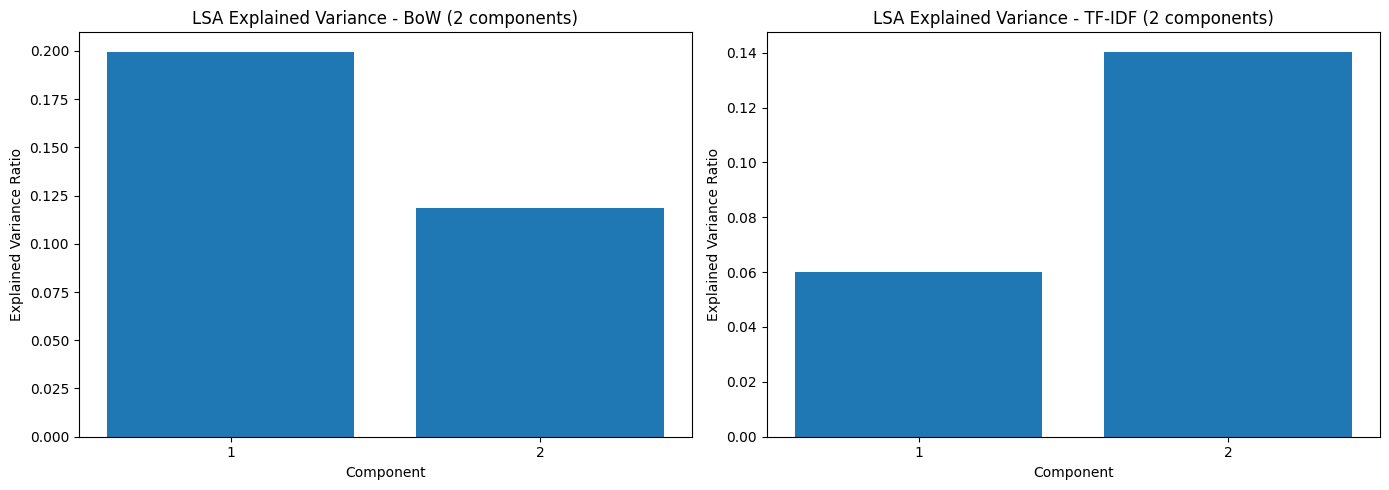

Saved: lsa_variance_2comp.png
[Creating 2D scatter plots...]


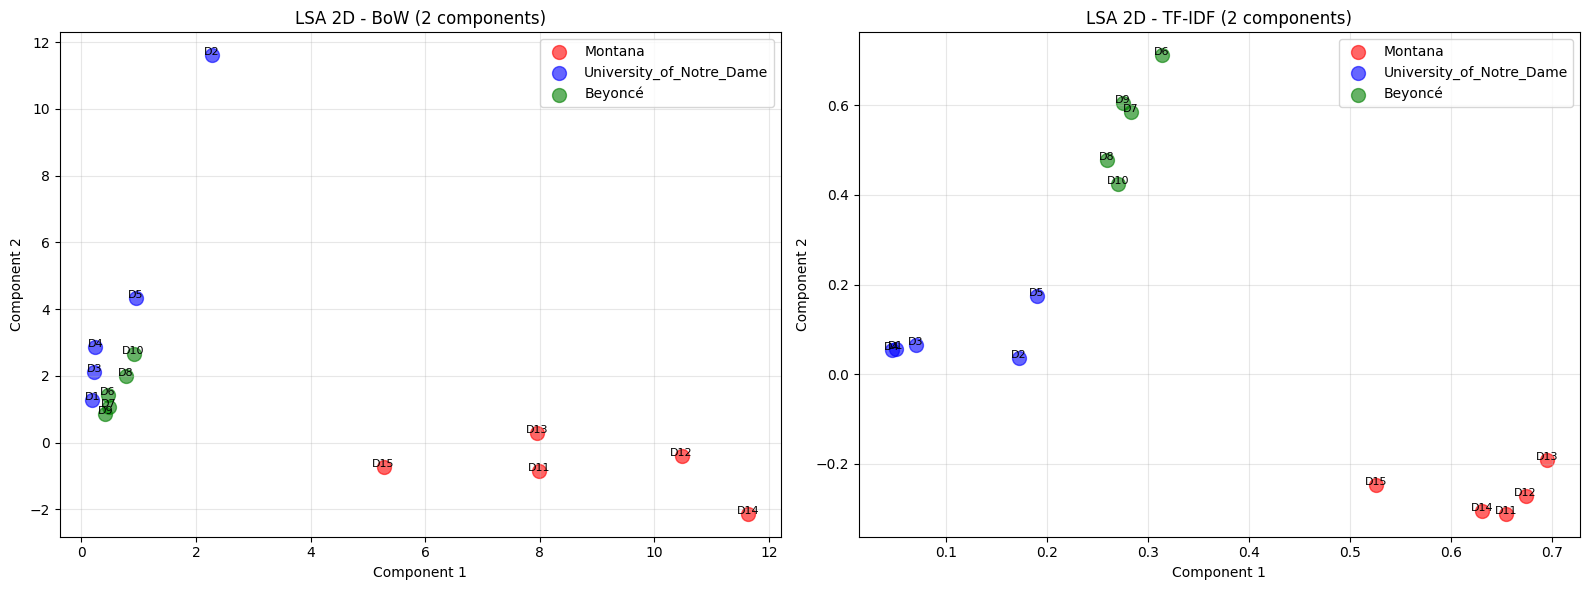

 Saved: lsa_2d_2comp.png
[Creating similarity heatmaps...]


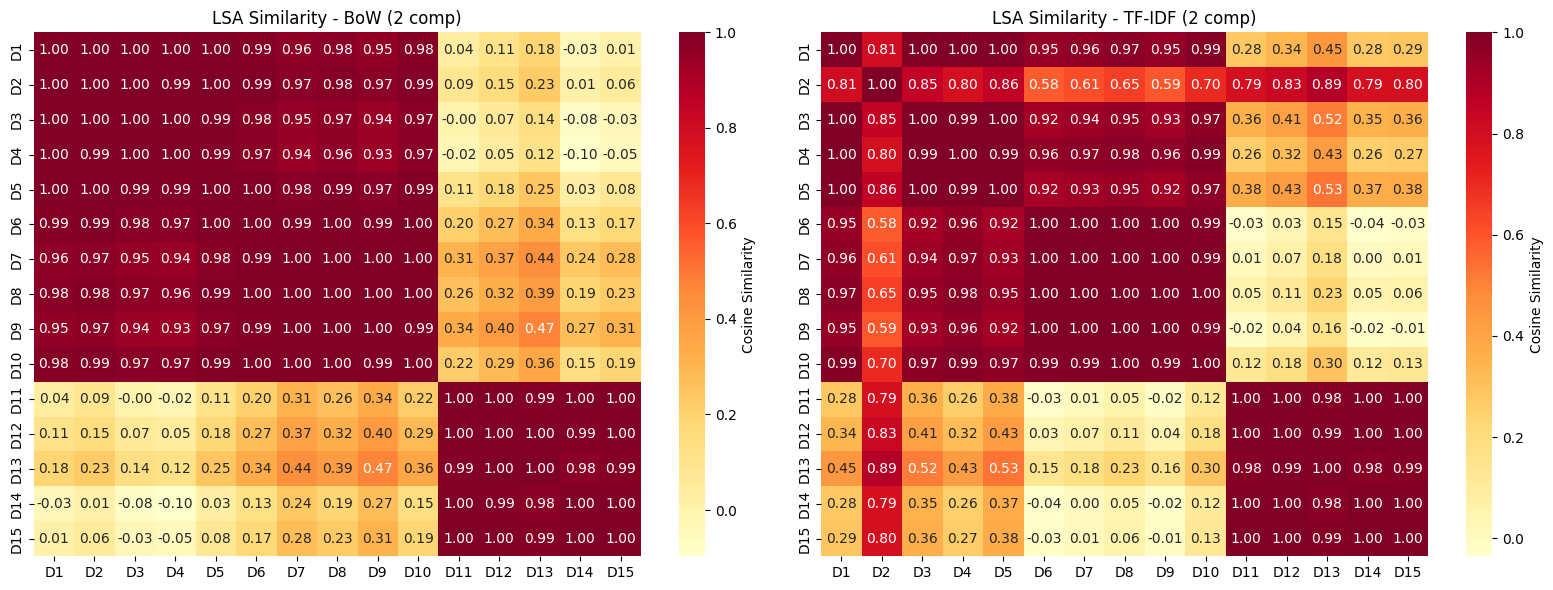

Saved: lsa_similarity_2comp.png

LSA WITH 3 COMPONENTS (TOPICS)

[2a] Applying SVD to Bag-of-Words (3 components)...
Original BoW shape: (15, 100)
Reduced LSA shape: (15, 3)
Explained variance: 40.89%
BoW - Explained Variance Ratio per component:
[0.19961392 0.11842472 0.09085535]

--- Top 10 words per LSA component (BoW) ---
Component 1: state, montana, adopted, legislature, mountain, song, population, th, butte, first
Component 2: student, published, observer, university, magazine, year, newspaper, paper, publication, journal
Component 3: beyonc, school, artist, also, song, music, year, child, knowles, album

[2b] Applying SVD to TF-IDF (3 components)...
Original TF-IDF shape: (15, 100)
Reduced LSA shape: (15, 3)
Explained variance: 29.53%

TF-IDF - Explained Variance Ratio per component:
[0.06021579 0.1403807  0.09469572]

--- Top 10 words per LSA component (TF-IDF) ---
Component 1: state, montana, adopted, beyonc, song, population, butte, mountain, legislature, school
Component 2: 

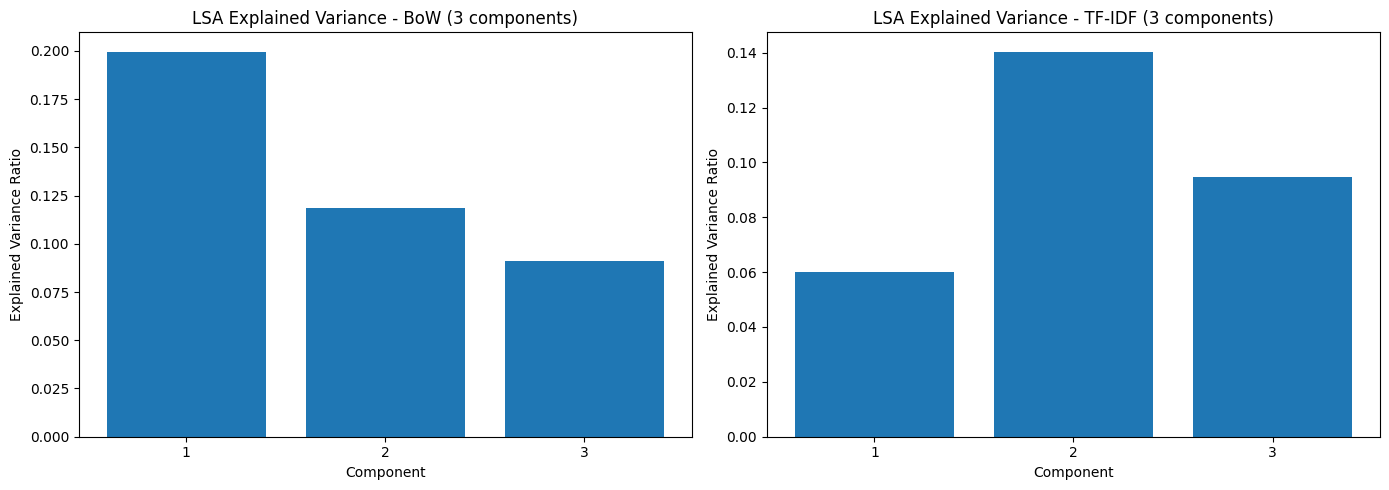

Saved: lsa_variance_3comp.png
[Creating 2D scatter plots...]


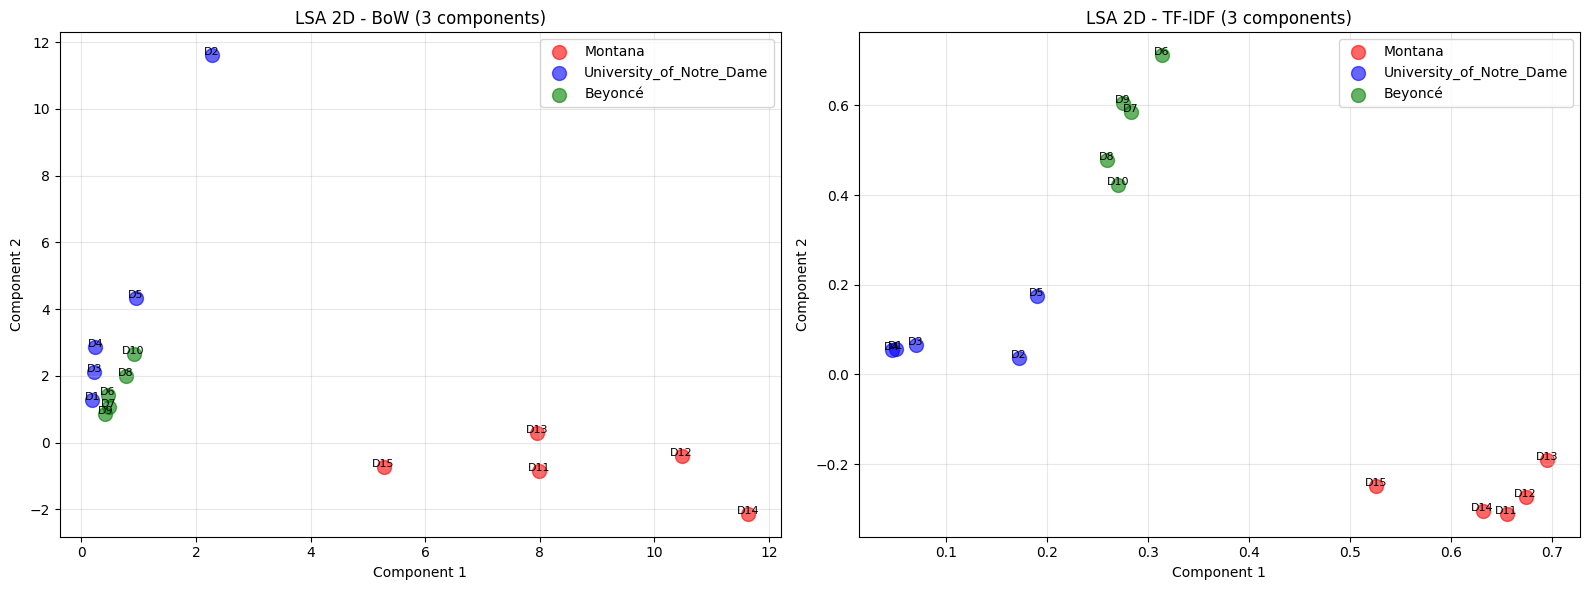

 Saved: lsa_2d_3comp.png
[Creating 3D scatter plots...]


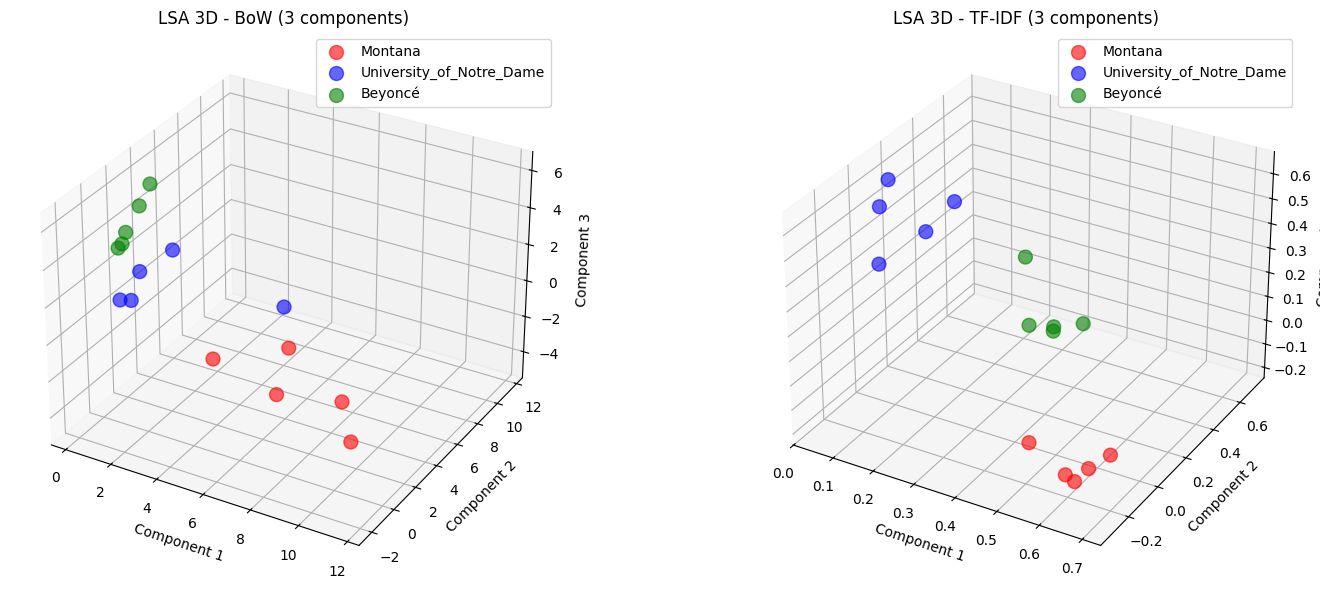

✓ Saved: lsa_3d_3comp.png
[Creating similarity heatmaps...]


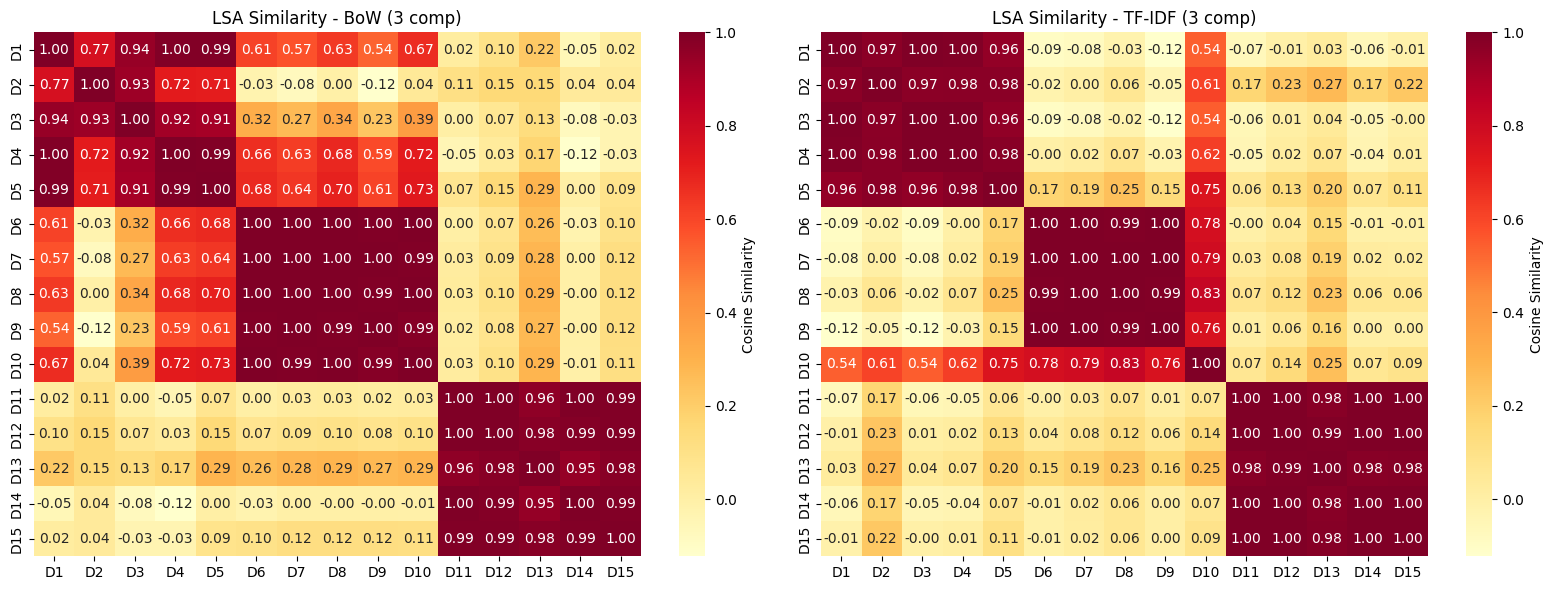

Saved: lsa_similarity_3comp.png

LSA WITH 4 COMPONENTS (TOPICS)

[2a] Applying SVD to Bag-of-Words (4 components)...
Original BoW shape: (15, 100)
Reduced LSA shape: (15, 4)
Explained variance: 50.50%
BoW - Explained Variance Ratio per component:
[0.19961392 0.11842477 0.0908552  0.09608918]

--- Top 10 words per LSA component (BoW) ---
Component 1: state, montana, adopted, legislature, mountain, song, population, th, butte, first
Component 2: student, published, observer, university, magazine, year, newspaper, paper, publication, journal
Component 3: beyonc, school, artist, also, song, music, year, child, knowles, album
Component 4: engineering, college, degree, science, five, program, study, part, established, year

[2b] Applying SVD to TF-IDF (4 components)...
Original TF-IDF shape: (15, 100)
Reduced LSA shape: (15, 4)
Explained variance: 38.56%

TF-IDF - Explained Variance Ratio per component:
[0.06021576 0.14038089 0.09469627 0.09029171]

--- Top 10 words per LSA component (TF-IDF

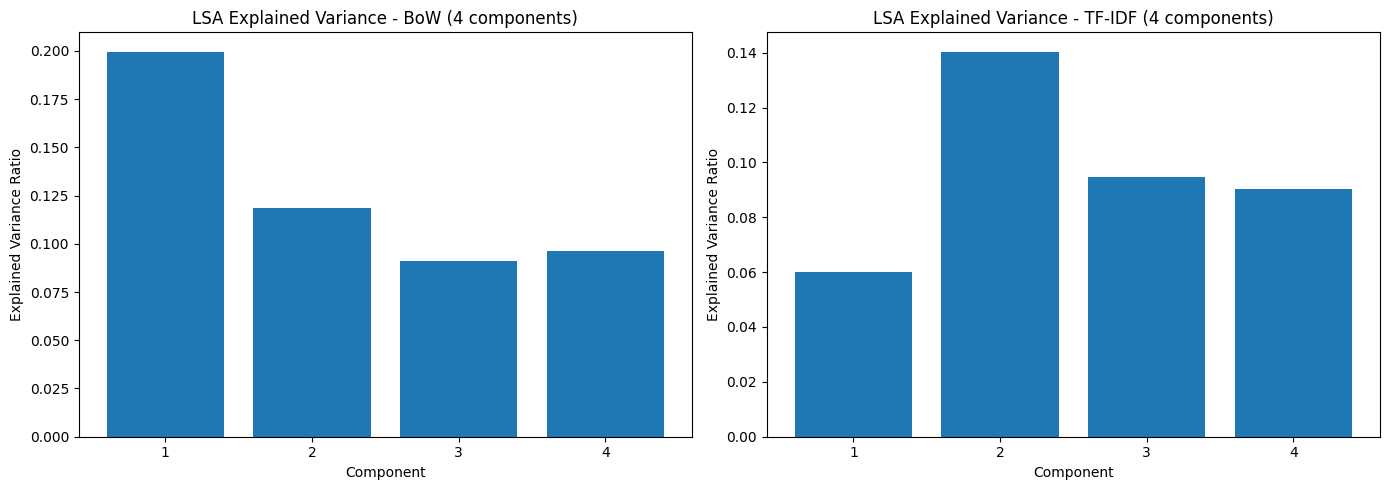

Saved: lsa_variance_4comp.png
[Creating 2D scatter plots...]


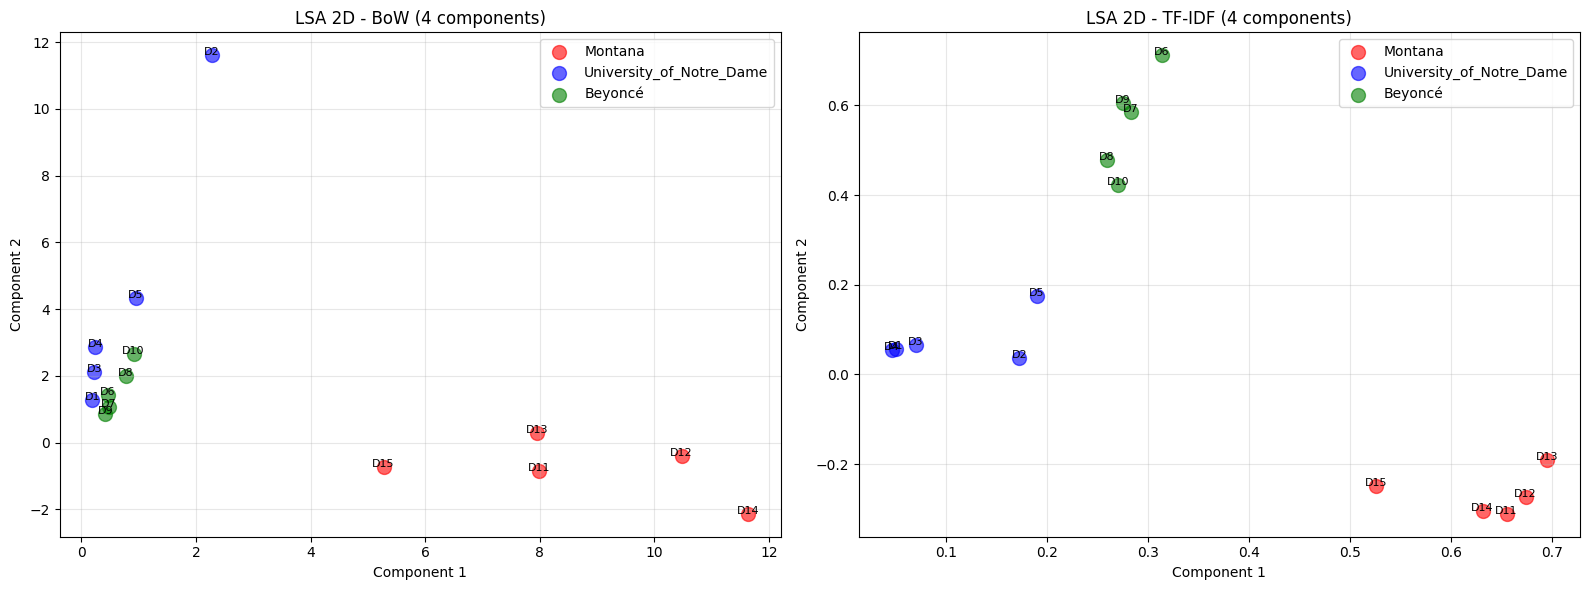

 Saved: lsa_2d_4comp.png
[Creating 3D scatter plots...]


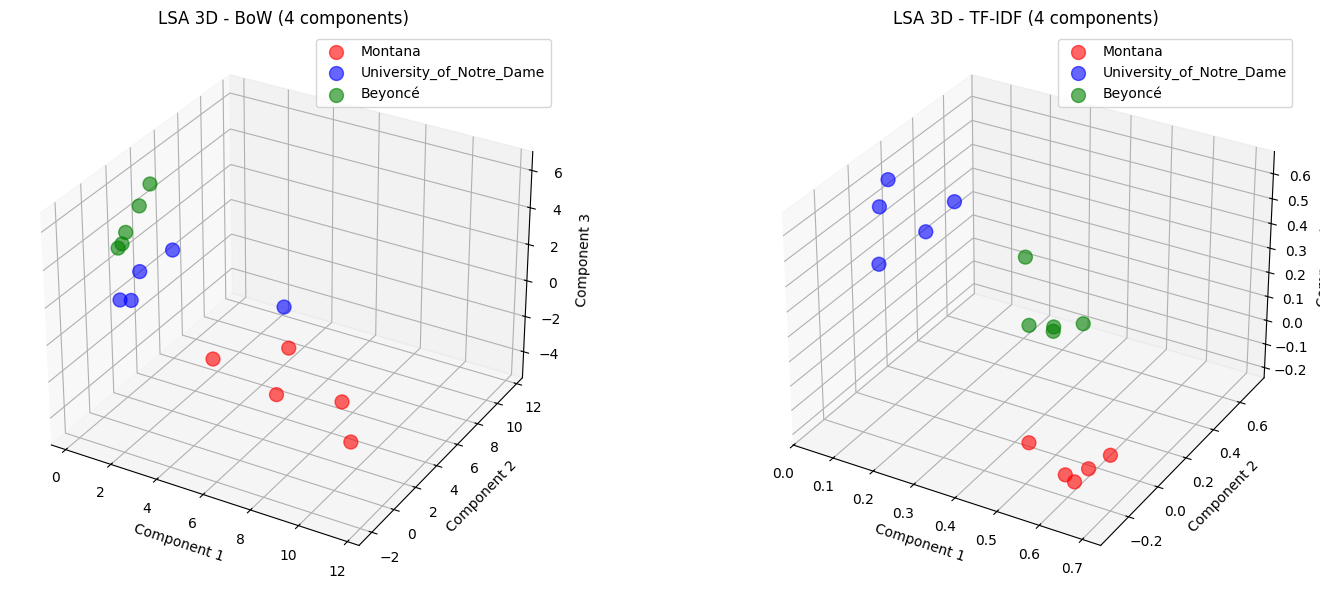

✓ Saved: lsa_3d_4comp.png
[Creating similarity heatmaps...]


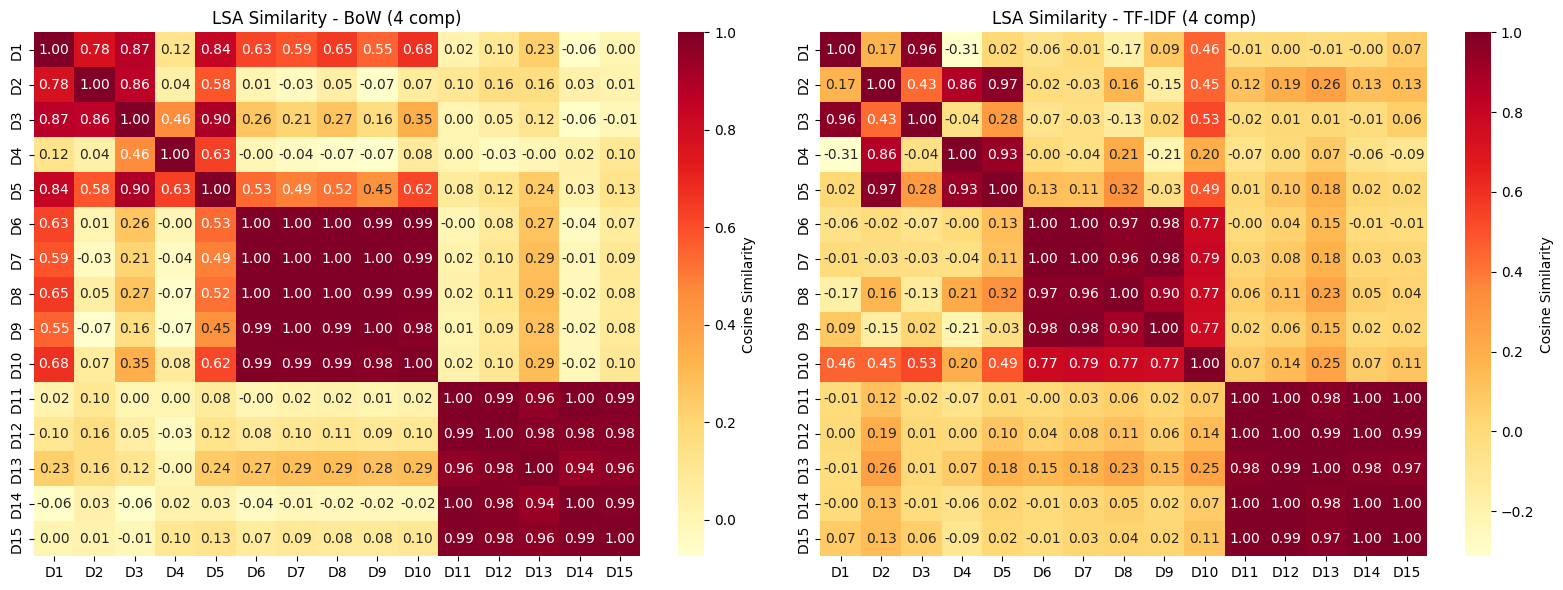

Saved: lsa_similarity_4comp.png

LSA WITH 5 COMPONENTS (TOPICS)

[2a] Applying SVD to Bag-of-Words (5 components)...
Original BoW shape: (15, 100)
Reduced LSA shape: (15, 5)
Explained variance: 57.84%
BoW - Explained Variance Ratio per component:
[0.19961392 0.11842476 0.09085526 0.09608919 0.07338211]

--- Top 10 words per LSA component (BoW) ---
Component 1: state, montana, adopted, legislature, mountain, song, population, th, butte, first
Component 2: student, published, observer, university, magazine, year, newspaper, paper, publication, journal
Component 3: beyonc, school, artist, also, song, music, year, child, knowles, album
Component 4: engineering, college, degree, science, five, program, study, part, established, year
Component 5: school, main, building, mary, statue, main building, seminary, st, moreau, moreau seminary

[2b] Applying SVD to TF-IDF (5 components)...
Original TF-IDF shape: (15, 100)
Reduced LSA shape: (15, 5)
Explained variance: 46.18%

TF-IDF - Explained Vari

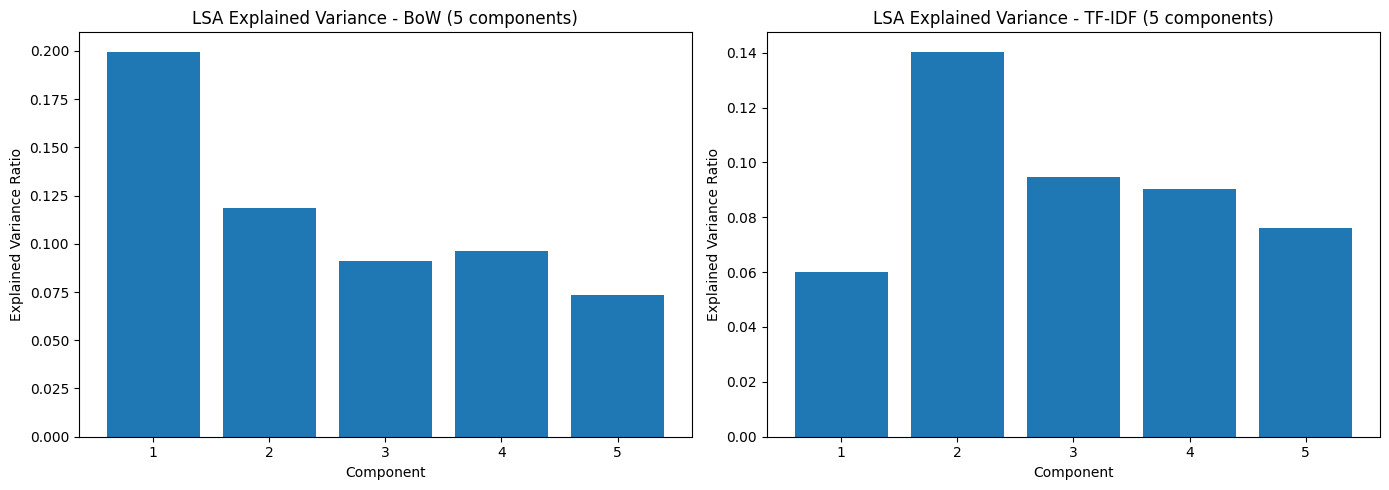

Saved: lsa_variance_5comp.png
[Creating 2D scatter plots...]


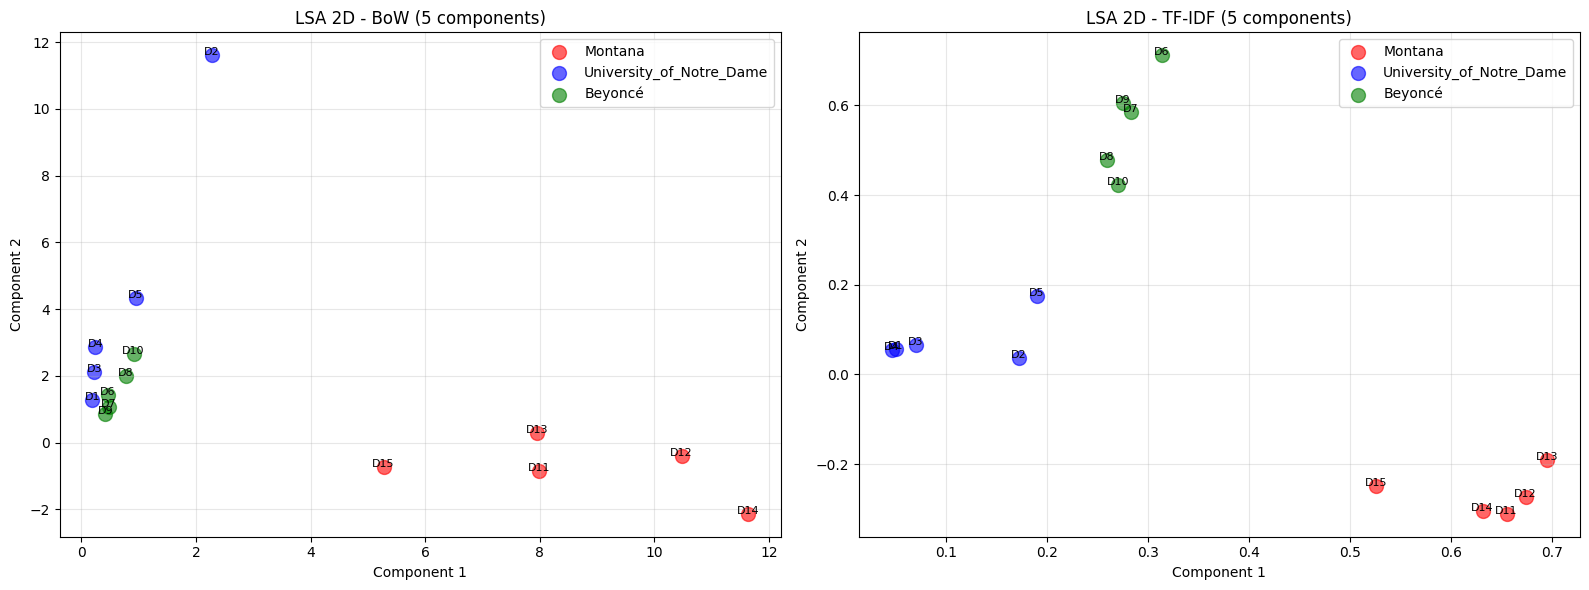

 Saved: lsa_2d_5comp.png
[Creating 3D scatter plots...]


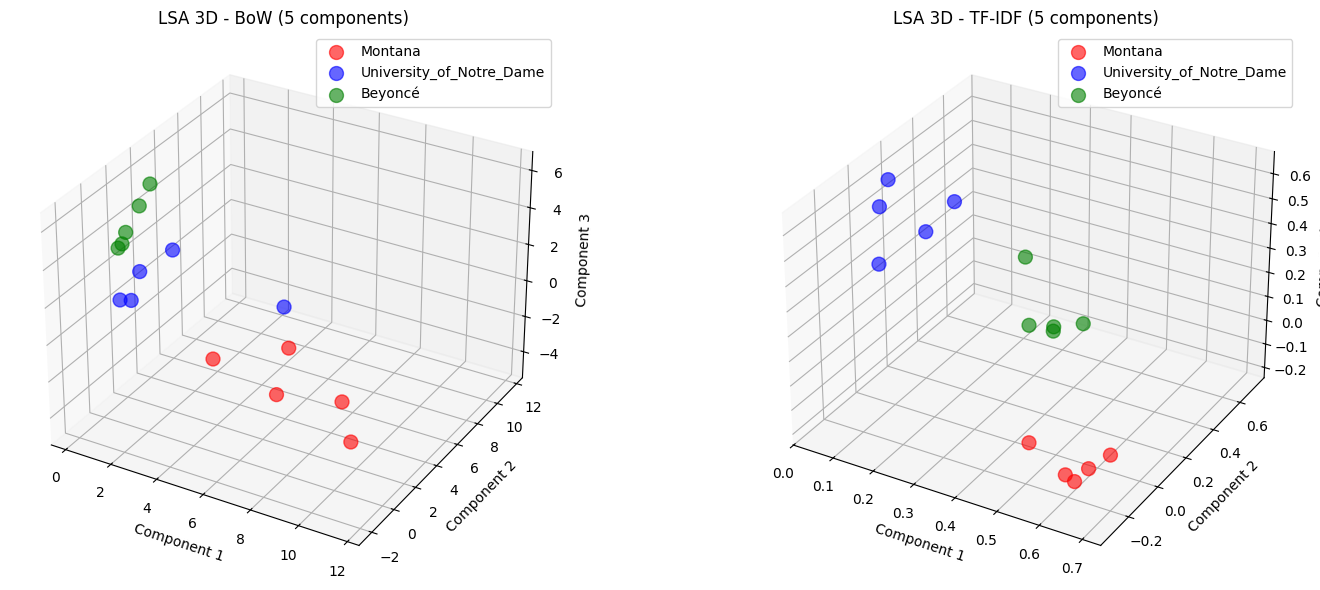

✓ Saved: lsa_3d_5comp.png
[Creating similarity heatmaps...]


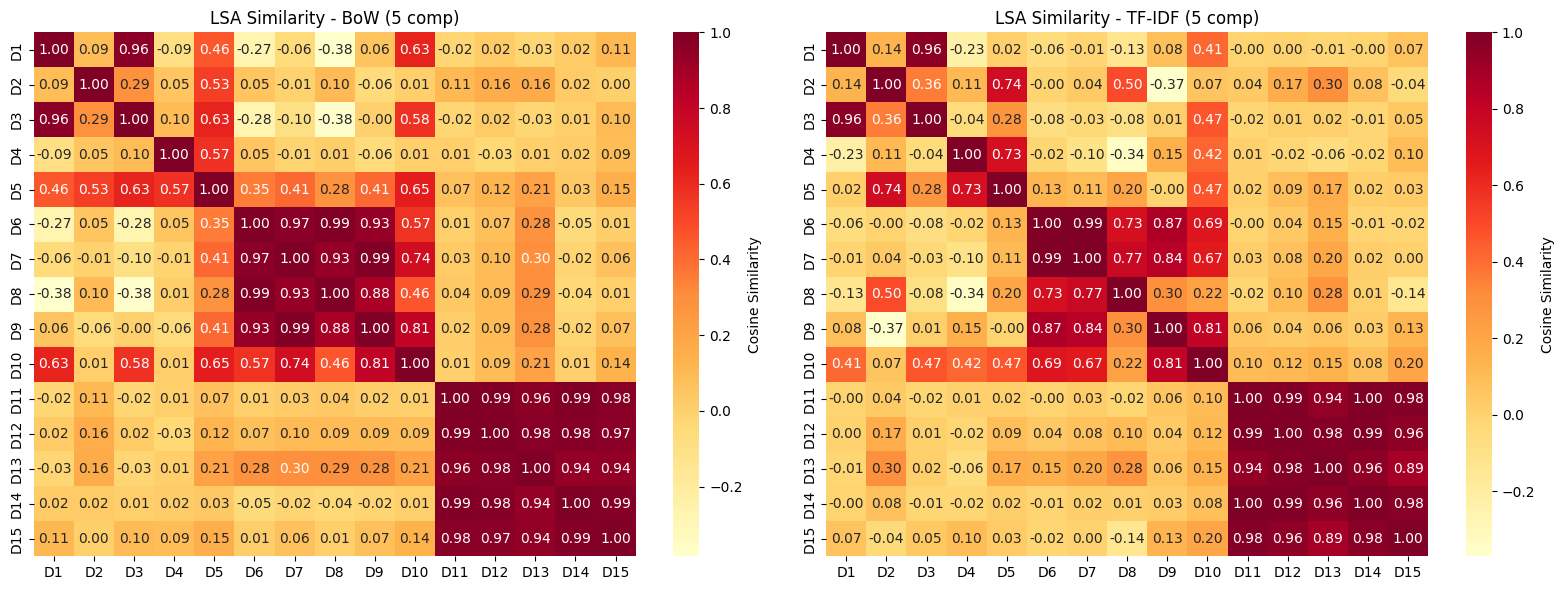

Saved: lsa_similarity_5comp.png


In [ ]:
print("POINT 2: LATENT SEMANTIC ANALYSIS (LSA) WITH SVD")
# SVD reduces dimensions while capturing semantic relationships
# It finds "latent" (hidden) topics/concepts in the documents

# Try different numbers of components (topics)
#✅ Higher explained variance = better representation of the original data (you’re preserving more of the information).
#⚠️ But higher variance isn’t always better, because it can also mean less abstraction and more noise.
n_components_list = [2, 3, 4, 5]

for n_components in n_components_list:
    print(f"\n{'='*80}")
    print(f"LSA WITH {n_components} COMPONENTS (TOPICS)")
    print(f"{'='*80}")

    # ========================================================================
    # 2a. LSA on Bag-of-Words
    # ========================================================================
    print(f"\n[2a] Applying SVD to Bag-of-Words ({n_components} components)...")

    svd_bow = TruncatedSVD(n_components=n_components, random_state=42)
    bow_lsa = svd_bow.fit_transform(bow_matrix)

    print(f"Original BoW shape: {bow_matrix.shape}")
    print(f"Reduced LSA shape: {bow_lsa.shape}")
    print(f"Explained variance: {svd_bow.explained_variance_ratio_.sum():.2%}")
    print("BoW - Explained Variance Ratio per component:")
    print(svd_bow.explained_variance_ratio_)

    print(f"\n--- Top 10 words per LSA component (BoW) ---")
    bow_terms = bow_vectorizer.get_feature_names_out()
    for i, comp in enumerate(svd_bow.components_):

        top_indices = comp.argsort()[-10:][::-1]
        top_words = [bow_terms[idx] for idx in top_indices]
        print(f"Component {i+1}: {', '.join(top_words)}")

    # ========================================================================
    # 2b. LSA on TF-IDF
    # ========================================================================
    print(f"\n[2b] Applying SVD to TF-IDF ({n_components} components)...")

    svd_tfidf = TruncatedSVD(n_components=n_components, random_state=42)
    tfidf_lsa = svd_tfidf.fit_transform(tfidf_matrix)

    print(f"Original TF-IDF shape: {tfidf_matrix.shape}")
    print(f"Reduced LSA shape: {tfidf_lsa.shape}")
    print(f"Explained variance: {svd_tfidf.explained_variance_ratio_.sum():.2%}")
    print("\nTF-IDF - Explained Variance Ratio per component:")
    print(svd_tfidf.explained_variance_ratio_)

    print(f"\n--- Top 10 words per LSA component (TF-IDF) ---")
    tfidf_terms = tfidf_vectorizer.get_feature_names_out()
    for i, comp in enumerate(svd_tfidf.components_):
        top_indices = comp.argsort()[-10:][::-1]
        top_words = [tfidf_terms[idx] for idx in top_indices]
        print(f"Component {i+1}: {', '.join(top_words)}")
    print(svd_tfidf.explained_variance_ratio_)

    # ========================================================================
    # VISUALIZATIONS
    # ========================================================================

    # 1. Explained Variance Plot
    print(f"\n[Creating variance plots...]")

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # BoW variance
    axes[0].bar(range(1, n_components+1), svd_bow.explained_variance_ratio_)
    axes[0].set_xlabel('Component')
    axes[0].set_ylabel('Explained Variance Ratio')
    axes[0].set_title(f'LSA Explained Variance - BoW ({n_components} components)')
    axes[0].set_xticks(range(1, n_components+1))

    # TF-IDF variance
    axes[1].bar(range(1, n_components+1), svd_tfidf.explained_variance_ratio_)
    axes[1].set_xlabel('Component')
    axes[1].set_ylabel('Explained Variance Ratio')
    axes[1].set_title(f'LSA Explained Variance - TF-IDF ({n_components} components)')
    axes[1].set_xticks(range(1, n_components+1))

    plt.tight_layout()
    plt.savefig(f'lsa_variance_{n_components}comp.png', dpi=300)
    plt.show()
    print(f"Saved: lsa_variance_{n_components}comp.png")

    # 2. 2D Scatter Plot (first 2 components)
    print(f"[Creating 2D scatter plots...]")

    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # BoW 2D plot
    colors = ['red', 'blue', 'green']
    topic_labels = [doc['topic'] for doc in documents]
    unique_topics = list(set(topic_labels))

    for i, topic_label in enumerate(unique_topics):
        indices = [j for j, t in enumerate(topic_labels) if t == topic_label]
        axes[0].scatter(bow_lsa[indices, 0], bow_lsa[indices, 1],
                       c=colors[i], label=topic_label[:25], s=100, alpha=0.6)
        for idx in indices:
            axes[0].annotate(f'D{idx+1}', (bow_lsa[idx, 0], bow_lsa[idx, 1]),
                           fontsize=8, ha='center')

    axes[0].set_xlabel('Component 1')
    axes[0].set_ylabel('Component 2')
    axes[0].set_title(f'LSA 2D - BoW ({n_components} components)')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # TF-IDF 2D plot
    for i, topic_label in enumerate(unique_topics):
        indices = [j for j, t in enumerate(topic_labels) if t == topic_label]
        axes[1].scatter(tfidf_lsa[indices, 0], tfidf_lsa[indices, 1],
                       c=colors[i], label=topic_label[:25], s=100, alpha=0.6)
        for idx in indices:
            axes[1].annotate(f'D{idx+1}', (tfidf_lsa[idx, 0], tfidf_lsa[idx, 1]),
                           fontsize=8, ha='center')

    axes[1].set_xlabel('Component 1')
    axes[1].set_ylabel('Component 2')
    axes[1].set_title(f'LSA 2D - TF-IDF ({n_components} components)')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(f'lsa_2d_{n_components}comp.png', dpi=300)
    plt.show()
    print(f" Saved: lsa_2d_{n_components}comp.png")

    # 3. 3D Scatter Plot (if 3+ components)
    if n_components >= 3:
        print(f"[Creating 3D scatter plots...]")

        fig = plt.figure(figsize=(16, 6))

        # BoW 3D
        ax1 = fig.add_subplot(121, projection='3d')
        for i, topic_label in enumerate(unique_topics):
            indices = [j for j, t in enumerate(topic_labels) if t == topic_label]
            ax1.scatter(bow_lsa[indices, 0], bow_lsa[indices, 1], bow_lsa[indices, 2],
                       c=colors[i], label=topic_label[:25], s=100, alpha=0.6)

        ax1.set_xlabel('Component 1')
        ax1.set_ylabel('Component 2')
        ax1.set_zlabel('Component 3')
        ax1.set_title(f'LSA 3D - BoW ({n_components} components)')
        ax1.legend()

        # TF-IDF 3D
        ax2 = fig.add_subplot(122, projection='3d')
        for i, topic_label in enumerate(unique_topics):
            indices = [j for j, t in enumerate(topic_labels) if t == topic_label]
            ax2.scatter(tfidf_lsa[indices, 0], tfidf_lsa[indices, 1], tfidf_lsa[indices, 2],
                       c=colors[i], label=topic_label[:25], s=100, alpha=0.6)

        ax2.set_xlabel('Component 1')
        ax2.set_ylabel('Component 2')
        ax2.set_zlabel('Component 3')
        ax2.set_title(f'LSA 3D - TF-IDF ({n_components} components)')
        ax2.legend()

        plt.tight_layout()
        plt.savefig(f'lsa_3d_{n_components}comp.png', dpi=300)
        plt.show()
        print(f"✓ Saved: lsa_3d_{n_components}comp.png")

    # 4. Document Similarity Heatmaps using LSA
    print(f"[Creating similarity heatmaps...]")

    from sklearn.metrics.pairwise import cosine_similarity

    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # BoW similarity
    bow_sim = cosine_similarity(bow_lsa)
    sns.heatmap(bow_sim, annot=True, fmt='.2f', cmap='YlOrRd',
                xticklabels=[f'D{i+1}' for i in range(15)],
                yticklabels=[f'D{i+1}' for i in range(15)],
                ax=axes[0], cbar_kws={'label': 'Cosine Similarity'})
    axes[0].set_title(f'LSA Similarity - BoW ({n_components} comp)')

    # TF-IDF similarity
    tfidf_sim = cosine_similarity(tfidf_lsa)
    sns.heatmap(tfidf_sim, annot=True, fmt='.2f', cmap='YlOrRd',
                xticklabels=[f'D{i+1}' for i in range(15)],
                yticklabels=[f'D{i+1}' for i in range(15)],
                ax=axes[1], cbar_kws={'label': 'Cosine Similarity'})
    axes[1].set_title(f'LSA Similarity - TF-IDF ({n_components} comp)')

    plt.tight_layout()
    plt.savefig(f'lsa_similarity_{n_components}comp.png', dpi=300)
    plt.show()
    print(f"Saved: lsa_similarity_{n_components}comp.png")



COMPARISON: BoW vs TF-IDF Performance in LSA
2 components: BoW=31.80%, TF-IDF=20.06%
3 components: BoW=40.89%, TF-IDF=29.53%
4 components: BoW=50.50%, TF-IDF=38.56%
5 components: BoW=57.84%, TF-IDF=46.18%


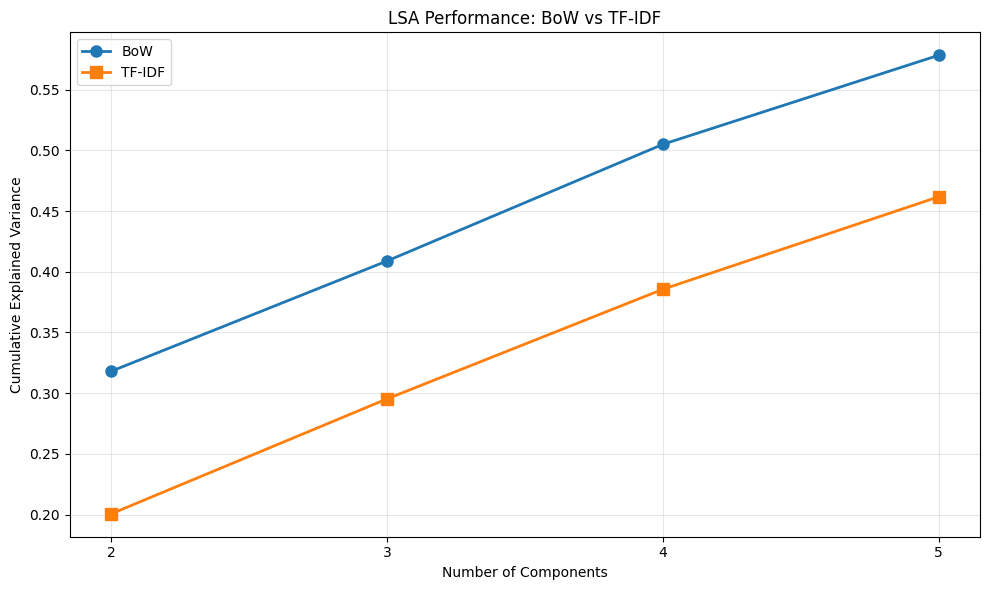

✓ Saved: lsa_comparison_bow_tfidf.png

POINT 2 COMPLETE - LSA WITH SVD

Generated files:
  - lsa_variance_2comp.png
  - lsa_2d_2comp.png
  - lsa_similarity_2comp.png
  - lsa_variance_3comp.png
  - lsa_2d_3comp.png
  - lsa_3d_3comp.png
  - lsa_similarity_3comp.png
  - lsa_variance_4comp.png
  - lsa_2d_4comp.png
  - lsa_3d_4comp.png
  - lsa_similarity_4comp.png
  - lsa_variance_5comp.png
  - lsa_2d_5comp.png
  - lsa_3d_5comp.png
  - lsa_similarity_5comp.png
  - lsa_comparison_bow_tfidf.png


In [ ]:
# ============================================================================
# COMPARISON: BoW vs TF-IDF for LSA
# ============================================================================

print("\n" + "=" * 80)
print("COMPARISON: BoW vs TF-IDF Performance in LSA")
print("=" * 80)

fig, ax = plt.subplots(figsize=(10, 6))

for n_comp in n_components_list:
    svd_bow_temp = TruncatedSVD(n_components=n_comp, random_state=42)
    svd_tfidf_temp = TruncatedSVD(n_components=n_comp, random_state=42)

    svd_bow_temp.fit(bow_matrix)
    svd_tfidf_temp.fit(tfidf_matrix)

    bow_var = svd_bow_temp.explained_variance_ratio_.sum()
    tfidf_var = svd_tfidf_temp.explained_variance_ratio_.sum()

    print(f"{n_comp} components: BoW={bow_var:.2%}, TF-IDF={tfidf_var:.2%}")

ax.plot(n_components_list,
        [TruncatedSVD(n, random_state=42).fit(bow_matrix).explained_variance_ratio_.sum()
         for n in n_components_list],
        marker='o', label='BoW', linewidth=2, markersize=8)

ax.plot(n_components_list,
        [TruncatedSVD(n, random_state=42).fit(tfidf_matrix).explained_variance_ratio_.sum()
         for n in n_components_list],
        marker='s', label='TF-IDF', linewidth=2, markersize=8)

ax.set_xlabel('Number of Components')
ax.set_ylabel('Cumulative Explained Variance')
ax.set_title('LSA Performance: BoW vs TF-IDF')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_xticks(n_components_list)
plt.tight_layout()
plt.savefig('lsa_comparison_bow_tfidf.png', dpi=300)
plt.show()
print(f"✓ Saved: lsa_comparison_bow_tfidf.png")

print("\n" + "=" * 80)
print("POINT 2 COMPLETE - LSA WITH SVD")
print("=" * 80)
print("\nGenerated files:")
for n in n_components_list:
    print(f"  - lsa_variance_{n}comp.png")
    print(f"  - lsa_2d_{n}comp.png")
    if n >= 3:
        print(f"  - lsa_3d_{n}comp.png")
    print(f"  - lsa_similarity_{n}comp.png")
print(f"  - lsa_comparison_bow_tfidf.png")


POINT 3: NON-NEGATIVE MATRIX FACTORIZATION (NMF)

NMF WITH 2 COMPONENTS (TOPICS)

Applying NMF to TF-IDF (2 components)...
✓ Original TF-IDF shape: (15, 100)
✓ NMF topics shape: (15, 2)
✓ Reconstruction error: 3.2363

--- Top 10 words per NMF topic ---

Topic 1:
  state                0.8785
  montana              0.6784
  adopted              0.2985
  population           0.2818
  mountain             0.2189
  butte                0.2175
  legislature          0.2110
  th                   0.1874
  song                 0.1872
  community            0.1737

Topic 2:
  beyonc               0.5358
  album                0.3100
  knowles              0.3085
  artist               0.2652
  school               0.2213
  child                0.2091
  record               0.1969
  group                0.1916
  singer               0.1884
  mathew               0.1843


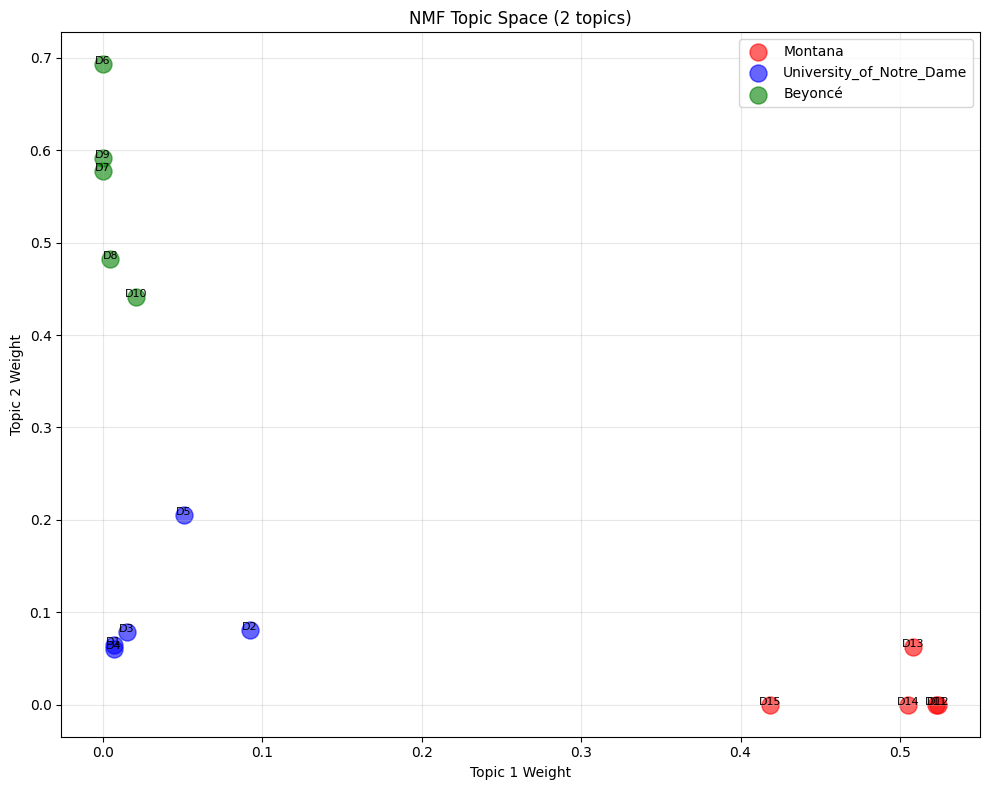

✓ Saved: nmf_2d_2topics.png


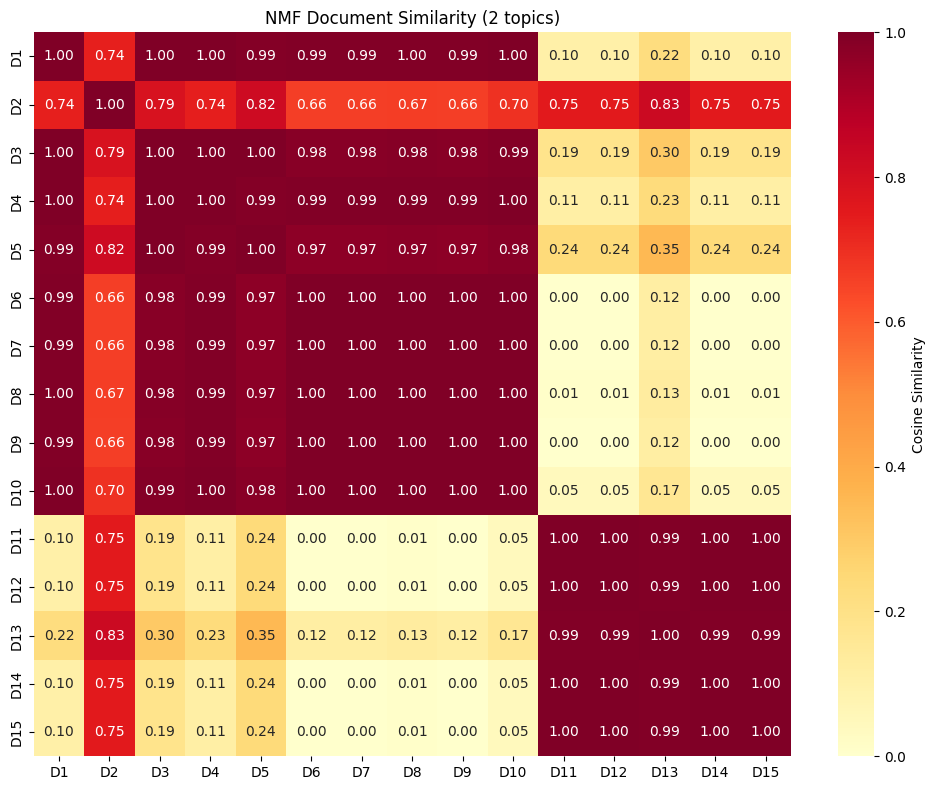

✓ Saved: nmf_similarity_2topics.png

NMF WITH 3 COMPONENTS (TOPICS)

Applying NMF to TF-IDF (3 components)...
✓ Original TF-IDF shape: (15, 100)
✓ NMF topics shape: (15, 3)
✓ Reconstruction error: 3.0100

--- Top 10 words per NMF topic ---

Topic 1:
  state                0.9080
  montana              0.7031
  adopted              0.3098
  population           0.2923
  mountain             0.2271
  butte                0.2252
  legislature          0.2184
  song                 0.1959
  th                   0.1944
  community            0.1801

Topic 2:
  beyonc               0.5522
  knowles              0.3334
  album                0.3334
  artist               0.2829
  child                0.2253
  record               0.2114
  group                0.2066
  singer               0.2033
  mathew               0.1993
  american             0.1993

Topic 3:
  program              0.3099
  main                 0.3044
  student              0.2893
  seminary             0.2638
  school  

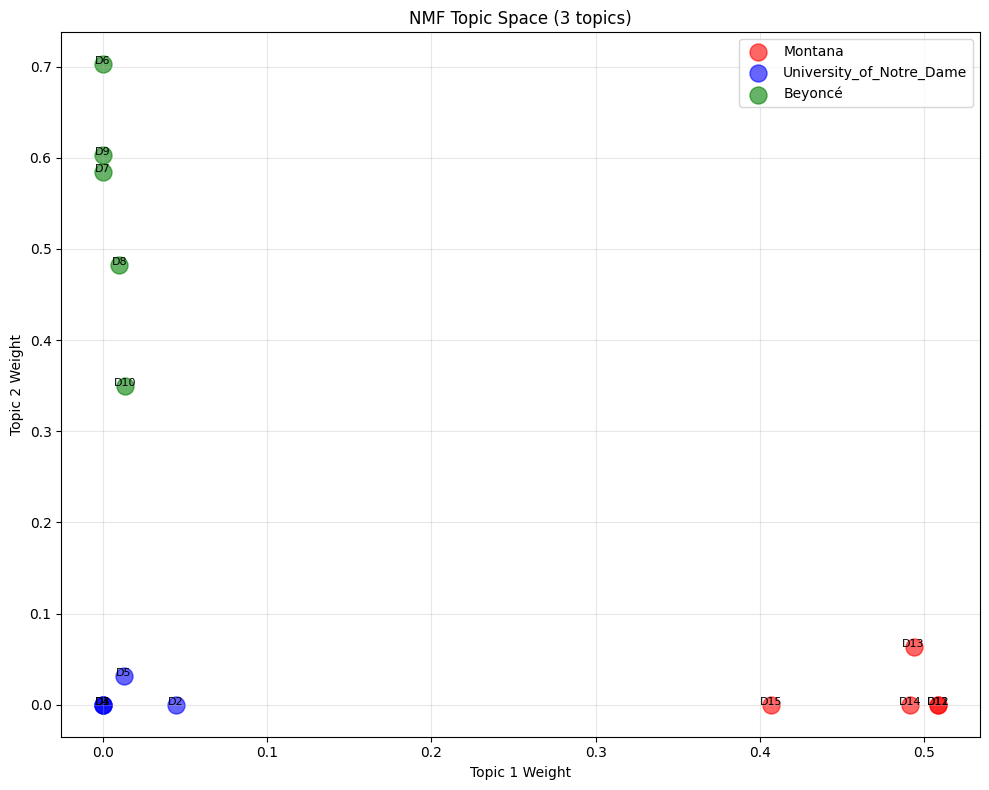

✓ Saved: nmf_2d_3topics.png


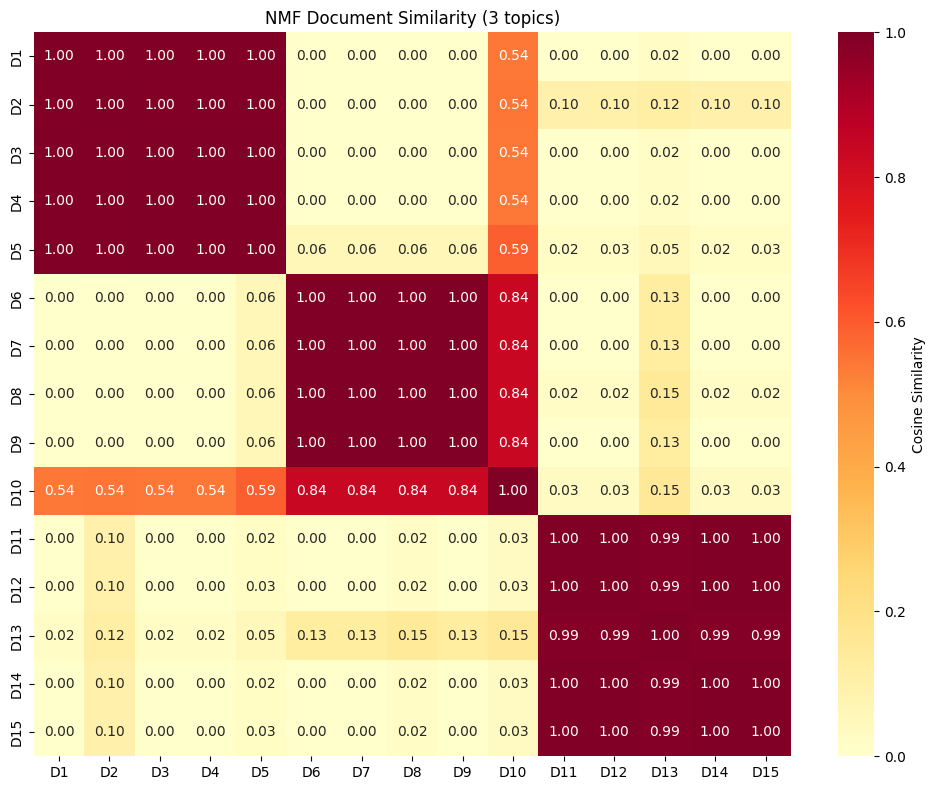

✓ Saved: nmf_similarity_3topics.png

NMF WITH 4 COMPONENTS (TOPICS)

Applying NMF to TF-IDF (4 components)...
✓ Original TF-IDF shape: (15, 100)
✓ NMF topics shape: (15, 4)
✓ Reconstruction error: 2.8166

--- Top 10 words per NMF topic ---

Topic 1:
  state                0.9219
  montana              0.7153
  adopted              0.3157
  population           0.2977
  mountain             0.2314
  butte                0.2285
  legislature          0.2220
  song                 0.1983
  th                   0.1981
  community            0.1834

Topic 2:
  beyonc               0.5640
  knowles              0.3402
  album                0.3399
  artist               0.2870
  child                0.2295
  record               0.2153
  group                0.2103
  singer               0.2072
  mathew               0.2033
  american             0.2033

Topic 3:
  main                 0.5569
  building             0.4622
  statue               0.4365
  seminary             0.4097
  main bui

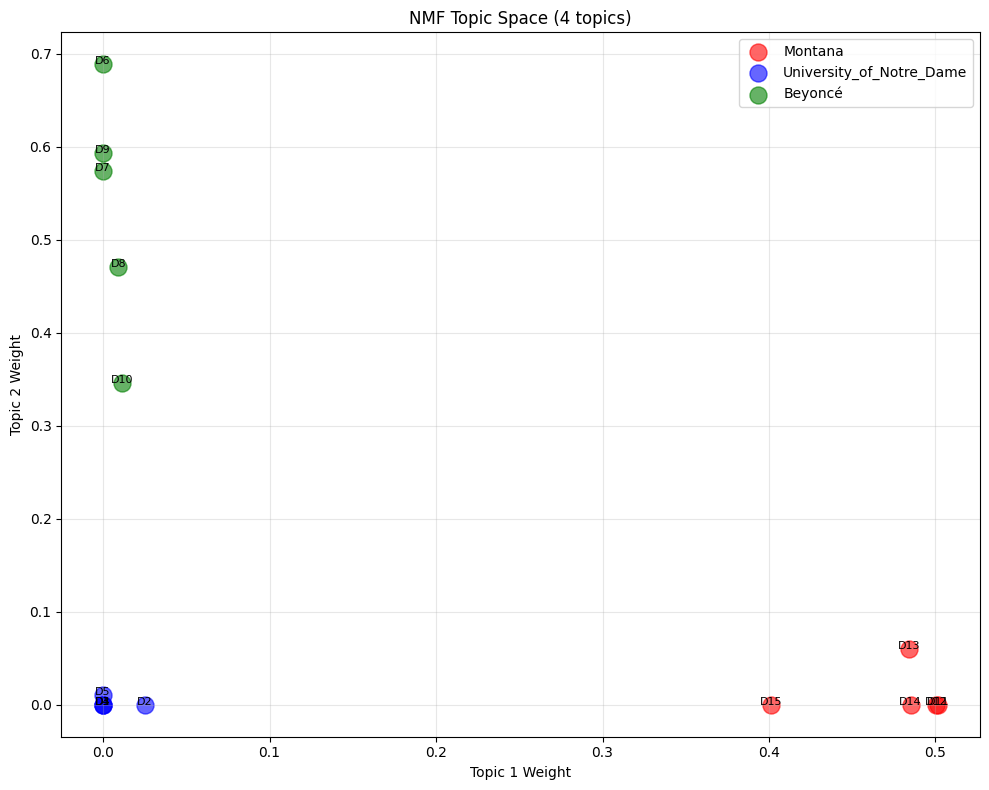

✓ Saved: nmf_2d_4topics.png


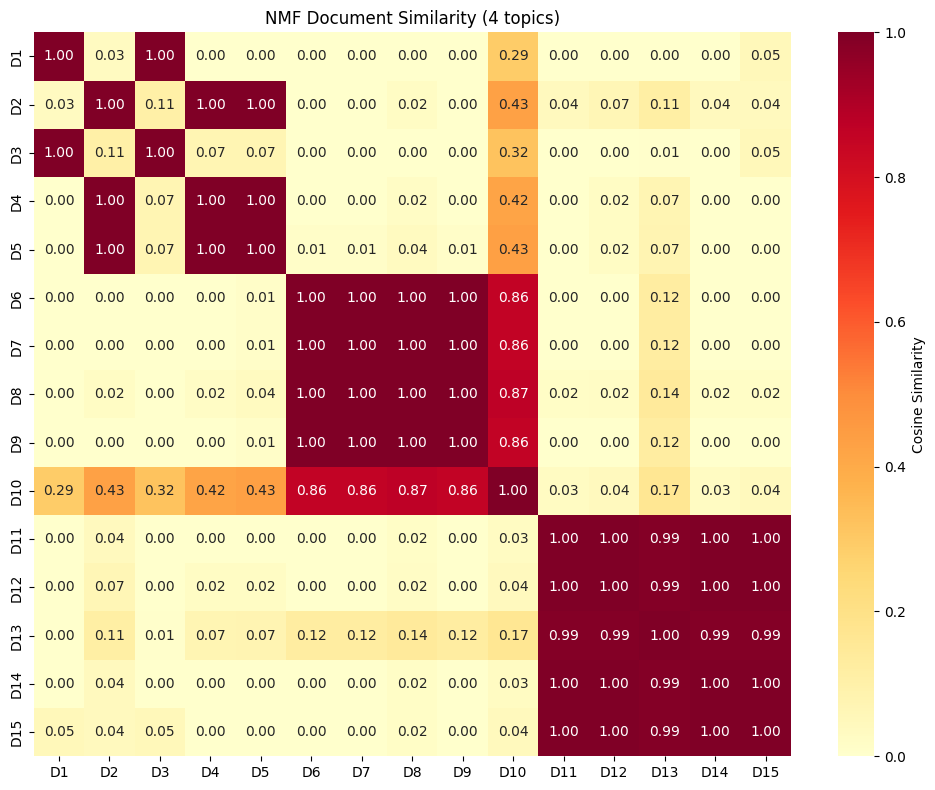

✓ Saved: nmf_similarity_4topics.png

NMF WITH 5 COMPONENTS (TOPICS)

Applying NMF to TF-IDF (5 components)...
✓ Original TF-IDF shape: (15, 100)
✓ NMF topics shape: (15, 5)
✓ Reconstruction error: 2.6459

--- Top 10 words per NMF topic ---

Topic 1:
  state                0.9457
  montana              0.7362
  adopted              0.3258
  population           0.3070
  mountain             0.2386
  butte                0.2345
  legislature          0.2279
  th                   0.2042
  song                 0.2025
  community            0.1892

Topic 2:
  beyonc               0.5853
  knowles              0.3563
  album                0.3556
  artist               0.2998
  child                0.2403
  record               0.2252
  group                0.2203
  singer               0.2170
  mathew               0.2130
  american             0.2130

Topic 3:
  main                 0.5994
  building             0.4974
  statue               0.4698
  seminary             0.4408
  main bui

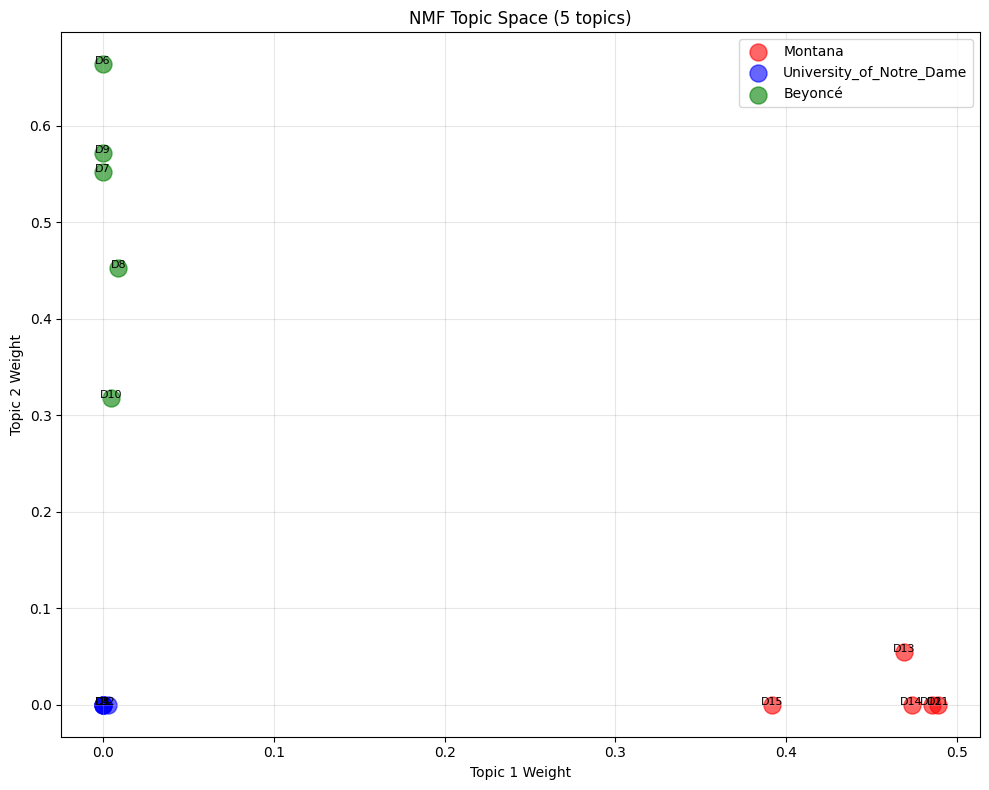

✓ Saved: nmf_2d_5topics.png


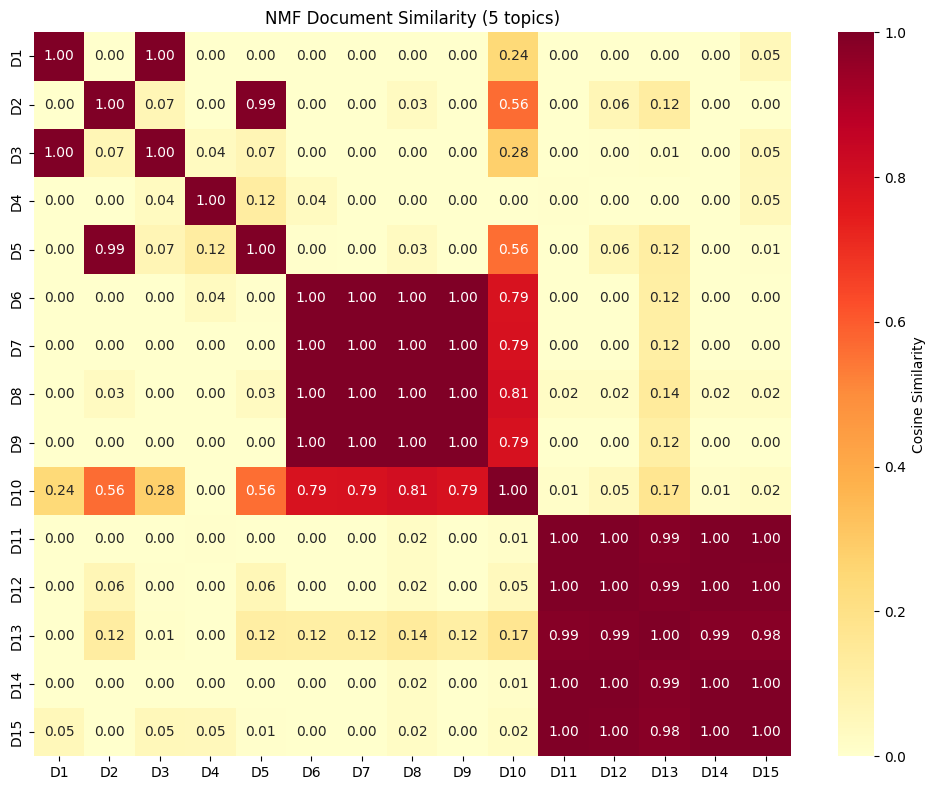

✓ Saved: nmf_similarity_5topics.png

--- NMF Reconstruction Error Comparison ---
2 topics: 3.2363 (lower is better)
3 topics: 3.0100 (lower is better)
4 topics: 2.8166 (lower is better)
5 topics: 2.6459 (lower is better)


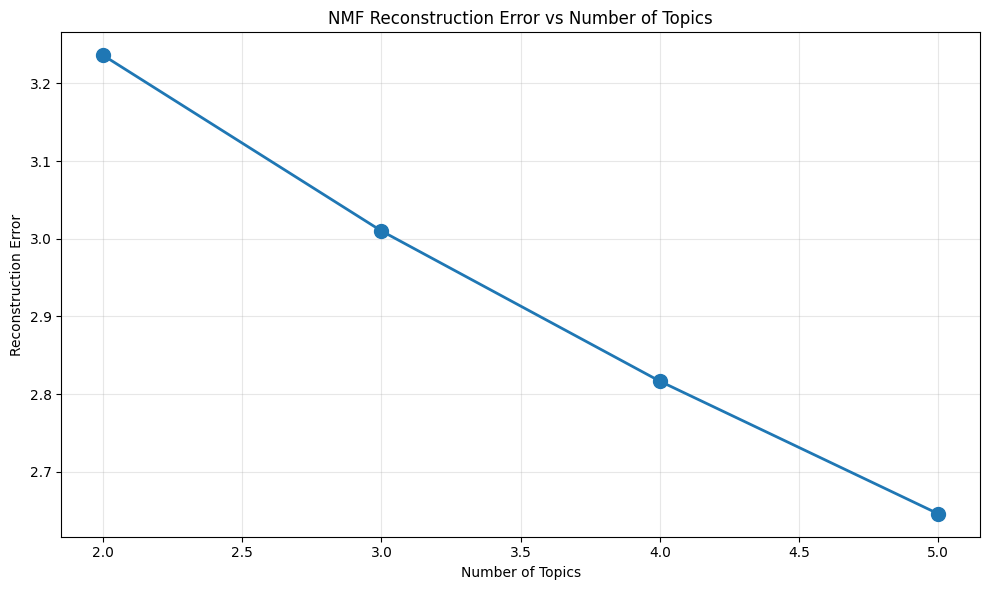

✓ Saved: nmf_reconstruction_error.png


In [ ]:
# ============================================================================
# POINT 3: NON-NEGATIVE MATRIX FACTORIZATION (NMF)
# ============================================================================

from sklearn.decomposition import NMF
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns

print("\n" + "=" * 80)
print("POINT 3: NON-NEGATIVE MATRIX FACTORIZATION (NMF)")
print("=" * 80)

# NMF works best with TF-IDF (non-negative values)
# Try different numbers of components
n_components_list = [2, 3, 4, 5]

nmf_results = {}

for n_components in n_components_list:
    print(f"\n{'='*80}")
    print(f"NMF WITH {n_components} COMPONENTS (TOPICS)")
    print(f"{'='*80}")

    # Apply NMF to TF-IDF matrix
    print(f"\nApplying NMF to TF-IDF ({n_components} components)...")

    nmf_model = NMF(
        n_components=n_components,
        random_state=42,
        max_iter=500,
        init='nndsvda'  # Better initialization
    )

    nmf_topics = nmf_model.fit_transform(tfidf_matrix)

    print(f"✓ Original TF-IDF shape: {tfidf_matrix.shape}")
    print(f"✓ NMF topics shape: {nmf_topics.shape}")
    print(f"✓ Reconstruction error: {nmf_model.reconstruction_err_:.4f}")

    # Show top words for each topic
    print(f"\n--- Top 10 words per NMF topic ---")
    tfidf_terms = tfidf_vectorizer.get_feature_names_out()

    for topic_idx, topic in enumerate(nmf_model.components_):
        top_indices = topic.argsort()[-10:][::-1]
        top_words = [tfidf_terms[idx] for idx in top_indices]
        top_weights = [topic[idx] for idx in top_indices]

        print(f"\nTopic {topic_idx + 1}:")
        for word, weight in zip(top_words, top_weights):
            print(f"  {word:20s} {weight:.4f}")

    # Store results for comparison
    nmf_results[n_components] = {
        'model': nmf_model,
        'topics': nmf_topics,
        'reconstruction_error': nmf_model.reconstruction_err_
    }

    # Visualizations
    if n_components >= 2:
        # 2D scatter plot
        fig, ax = plt.subplots(figsize=(10, 8))
        colors = ['red', 'blue', 'green']
        topic_labels = [doc['topic'] for doc in documents]
        unique_topics = list(set(topic_labels))

        for i, topic_label in enumerate(unique_topics):
            indices = [j for j, t in enumerate(topic_labels) if t == topic_label]
            ax.scatter(nmf_topics[indices, 0], nmf_topics[indices, 1],
                      c=colors[i], label=topic_label[:30], s=150, alpha=0.6)
            for idx in indices:
                ax.annotate(f'D{idx+1}',
                          (nmf_topics[idx, 0], nmf_topics[idx, 1]),
                          fontsize=8, ha='center')

        ax.set_xlabel('Topic 1 Weight')
        ax.set_ylabel('Topic 2 Weight')
        ax.set_title(f'NMF Topic Space ({n_components} topics)')
        ax.legend()
        ax.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig(f'nmf_2d_{n_components}topics.png', dpi=300)
        plt.show()
        print(f"✓ Saved: nmf_2d_{n_components}topics.png")

    # Similarity heatmap
    nmf_similarity = cosine_similarity(nmf_topics)

    plt.figure(figsize=(10, 8))
    sns.heatmap(nmf_similarity, annot=True, fmt='.2f', cmap='YlOrRd',
                xticklabels=[f'D{i+1}' for i in range(15)],
                yticklabels=[f'D{i+1}' for i in range(15)],
                cbar_kws={'label': 'Cosine Similarity'})
    plt.title(f'NMF Document Similarity ({n_components} topics)')
    plt.tight_layout()
    plt.savefig(f'nmf_similarity_{n_components}topics.png', dpi=300)
    plt.show()
    print(f"✓ Saved: nmf_similarity_{n_components}topics.png")

# Compare reconstruction errors
print(f"\n--- NMF Reconstruction Error Comparison ---")
for n_comp, results in nmf_results.items():
    print(f"{n_comp} topics: {results['reconstruction_error']:.4f} (lower is better)")

plt.figure(figsize=(10, 6))
plt.plot(list(nmf_results.keys()),
         [r['reconstruction_error'] for r in nmf_results.values()],
         marker='o', linewidth=2, markersize=10)
plt.xlabel('Number of Topics')
plt.ylabel('Reconstruction Error')
plt.title('NMF Reconstruction Error vs Number of Topics')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('nmf_reconstruction_error.png', dpi=300)
plt.show()
print(f"✓ Saved: nmf_reconstruction_error.png")





POINT 4: LATENT DIRICHLET ALLOCATION (LDA)

LDA WITH 2 TOPICS

Training LDA with 2 topics...
Original BoW shape: (15, 100)
LDA topics shape: (15, 2)
Log-likelihood: -2152.33
Perplexity: 87.77 (lower is better)

--- Top 10 words per LDA topic ---

Topic 1:
  state                31.8922
  montana              23.4990
  adopted              8.4995
  population           7.4993
  legislature          6.4990
  main                 6.4987
  mountain             5.4994
  th                   5.4993
  building             5.4986
  butte                5.4983

Topic 2:
  beyonc               14.4988
  year                 9.6302
  school               9.5465
  student              9.5442
  engineering          8.4991
  college              7.5791
  artist               7.4992
  one                  6.5855
  also                 6.5313
  program              6.4991

--- Document Topic Distributions (Probabilities) ---
Doc 1 (University_of_Notre_Dame ): T1=0.98 T2=0.02 → Dominant: T1 (97.5%)
Do

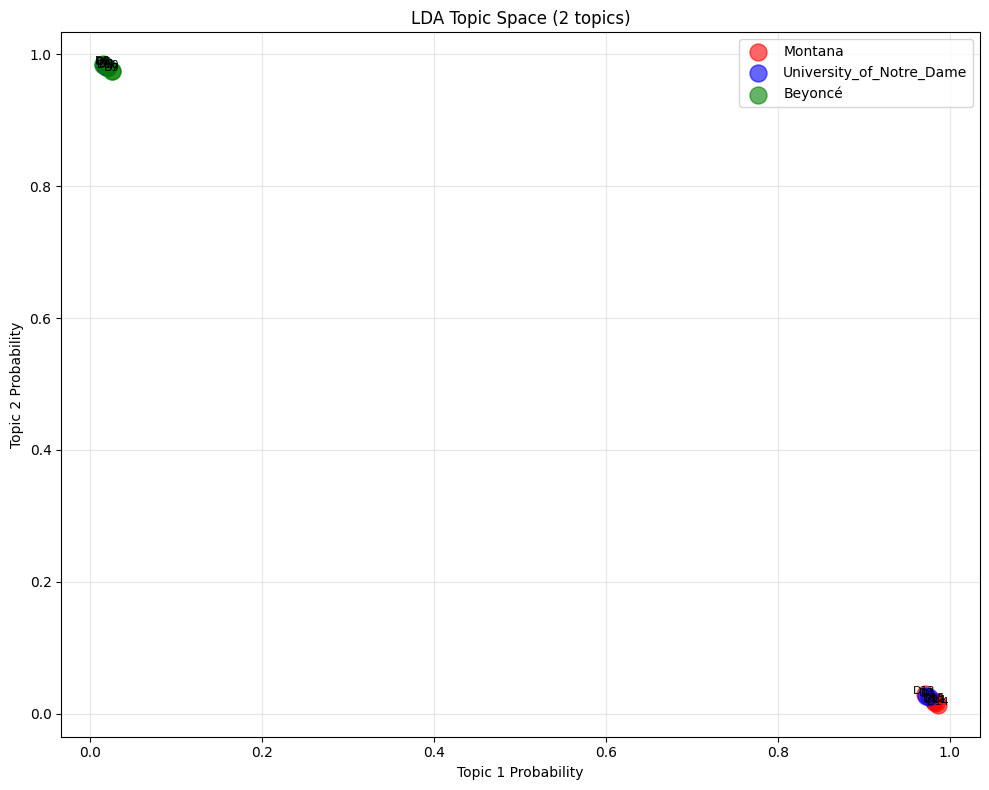

✓ Saved: lda_2d_2topics.png


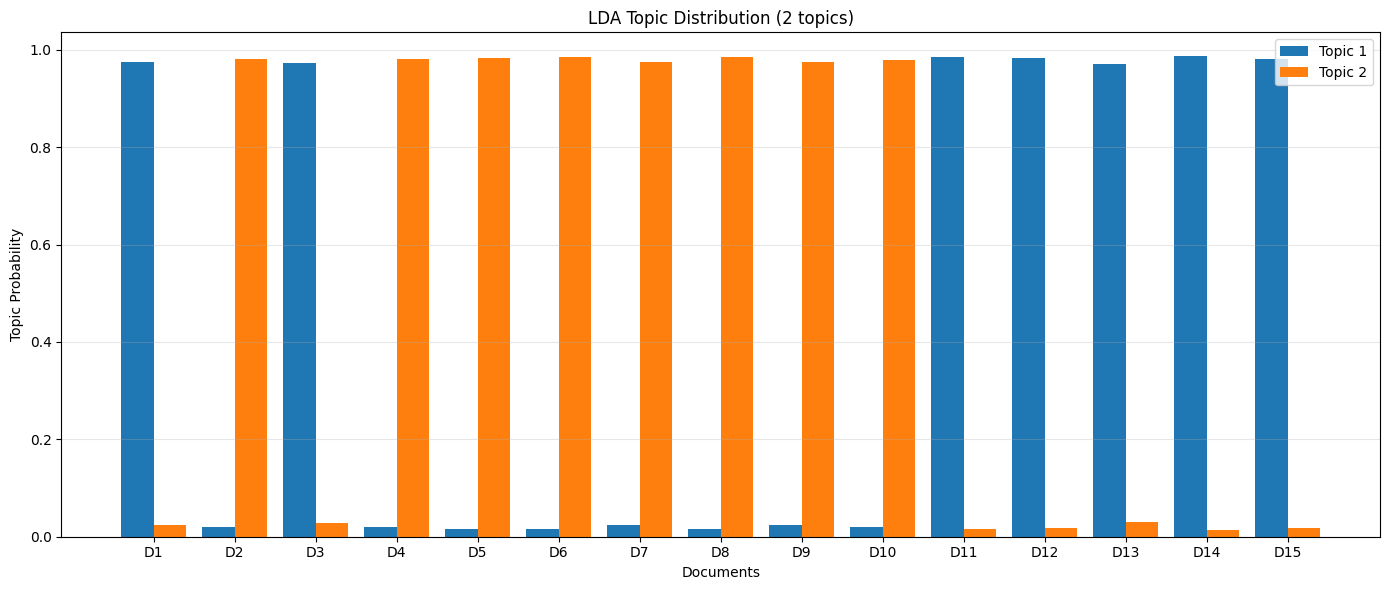

✓ Saved: lda_distribution_2topics.png

LDA WITH 3 TOPICS

Training LDA with 3 topics...
Original BoW shape: (15, 100)
LDA topics shape: (15, 3)
Log-likelihood: -2149.62
Perplexity: 87.28 (lower is better)

--- Top 10 words per LDA topic ---

Topic 1:
  beyonc               9.7968
  school               9.3614
  year                 7.3726
  artist               7.3277
  also                 5.3648
  program              5.3418
  music                5.3332
  album                5.3252
  one                  4.9857
  song                 4.3450

Topic 2:
  engineering          8.3332
  student              7.3761
  college              6.3888
  knowles              5.3049
  beyonc               4.8697
  published            4.3333
  observer             4.3333
  science              4.3332
  university           3.3490
  newspaper            3.3430

Topic 3:
  state                31.3535
  montana              23.3331
  adopted              8.3332
  population           7.3331
  legis

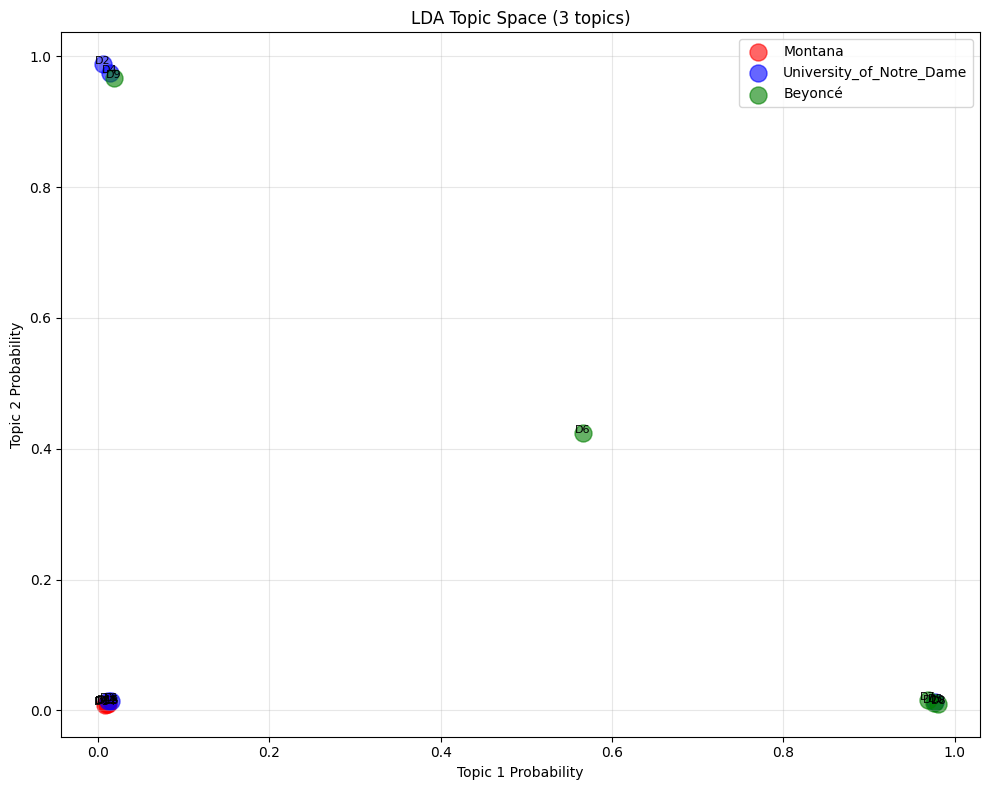

✓ Saved: lda_2d_3topics.png


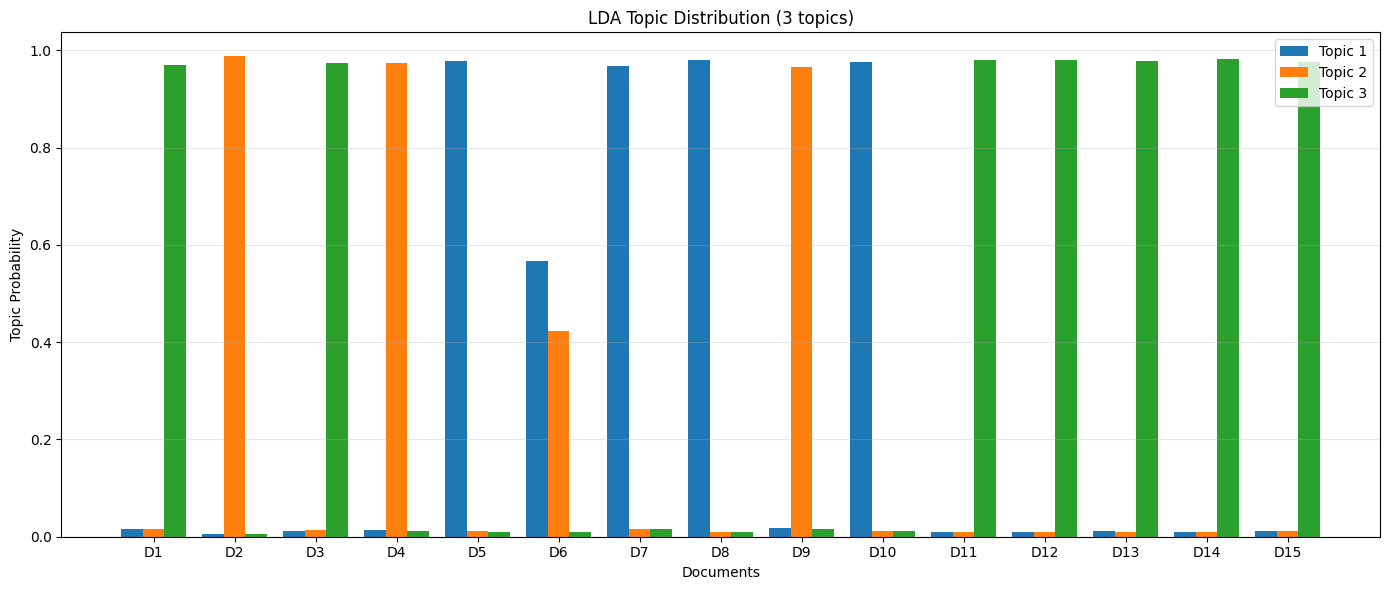

✓ Saved: lda_distribution_3topics.png

LDA WITH 4 TOPICS

Training LDA with 4 topics...
Original BoW shape: (15, 100)
LDA topics shape: (15, 4)
Log-likelihood: -2169.43
Perplexity: 90.94 (lower is better)

--- Top 10 words per LDA topic ---

Topic 1:
  school               9.2554
  year                 6.2600
  artist               6.2533
  program              5.2532
  also                 5.2518
  beyonc               5.2475
  music                4.2536
  community            4.2321
  one                  3.2532
  first                3.2525

Topic 2:
  beyonc               9.2524
  engineering          8.2500
  college              5.2578
  knowles              5.2500
  album                5.2500
  child                4.2544
  group                3.2516
  five                 3.2516
  destiny child        3.2515
  destiny              3.2515

Topic 3:
  state                16.2527
  montana              7.2481
  main                 6.2500
  song                 5.2542
  buildi

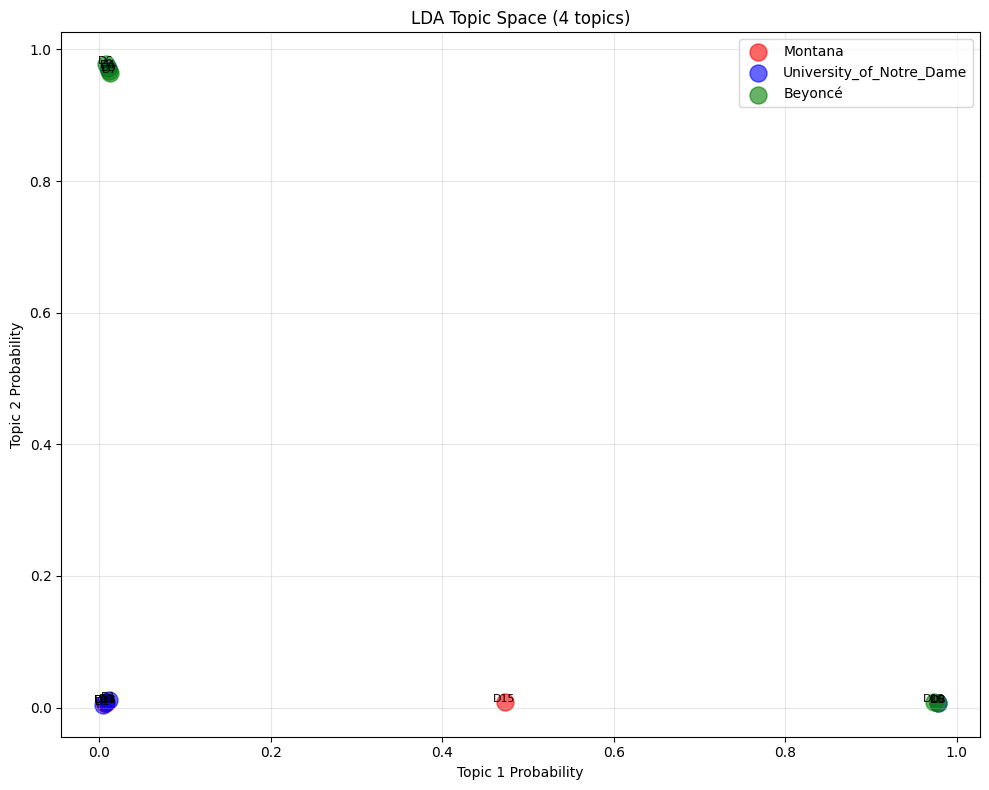

✓ Saved: lda_2d_4topics.png


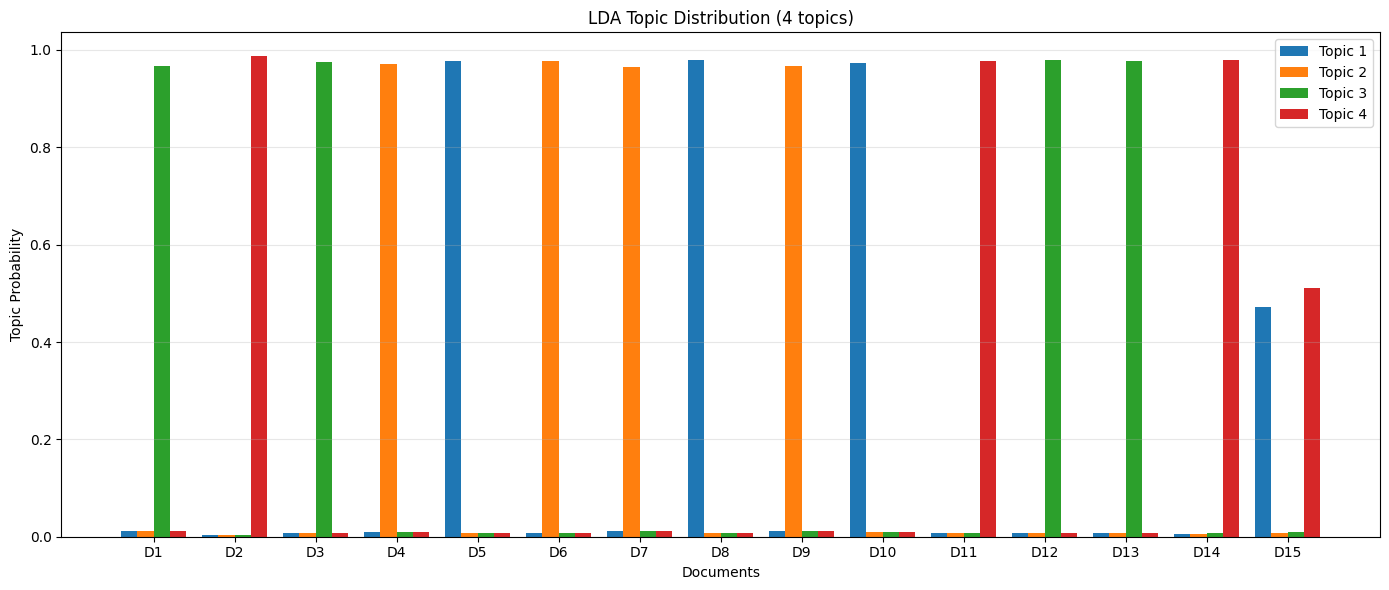

✓ Saved: lda_distribution_4topics.png

LDA WITH 5 TOPICS

Training LDA with 5 topics...
Original BoW shape: (15, 100)
LDA topics shape: (15, 5)
Log-likelihood: -2150.24
Perplexity: 87.39 (lower is better)

--- Top 10 words per LDA topic ---

Topic 1:
  school               7.2021
  artist               6.2009
  population           5.2009
  montana              5.1991
  beyonc               5.1989
  also                 4.2015
  music                4.2010
  community            4.2000
  year                 3.2010
  song                 3.2006

Topic 2:
  beyonc               9.2011
  knowles              5.2000
  album                5.2000
  child                4.2019
  group                3.2007
  destiny child        3.2006
  destiny              3.2006
  record               3.2006
  singer               3.2000
  american             3.2000

Topic 3:
  state                16.2029
  montana              7.1995
  main                 6.2000
  song                 5.2010
  buildi

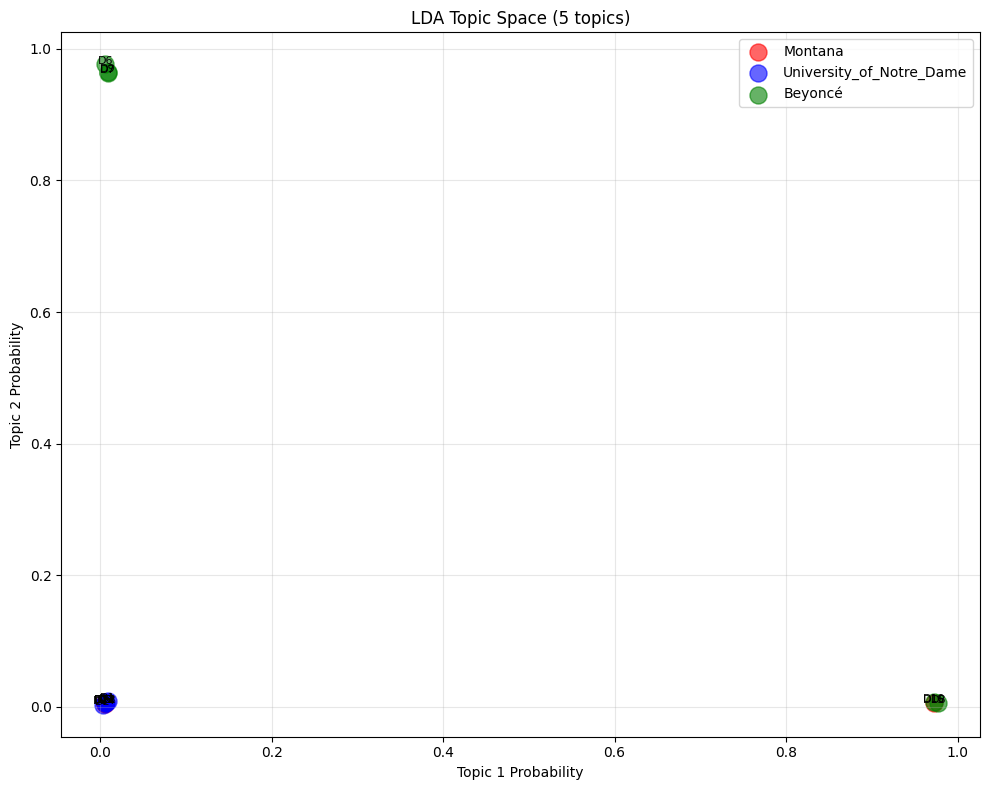

✓ Saved: lda_2d_5topics.png


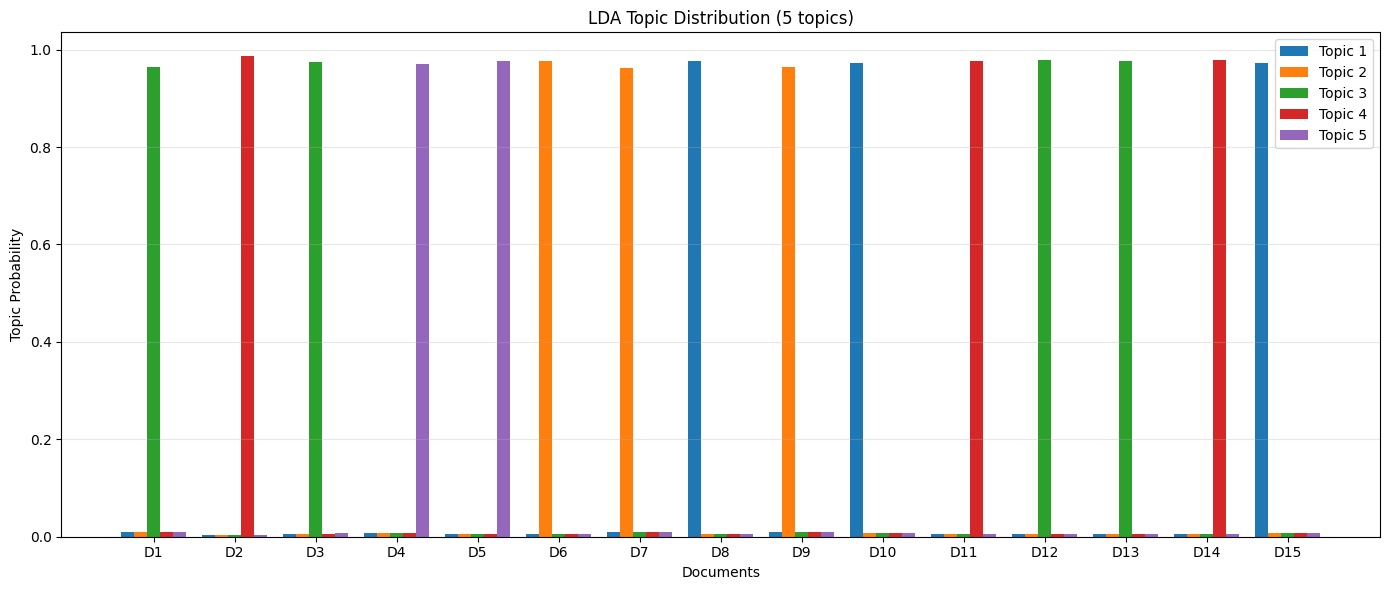

✓ Saved: lda_distribution_5topics.png

--- LDA Perplexity Comparison ---
2 topics: 87.77 (lower is better)
3 topics: 87.28 (lower is better)
4 topics: 90.94 (lower is better)
5 topics: 87.39 (lower is better)


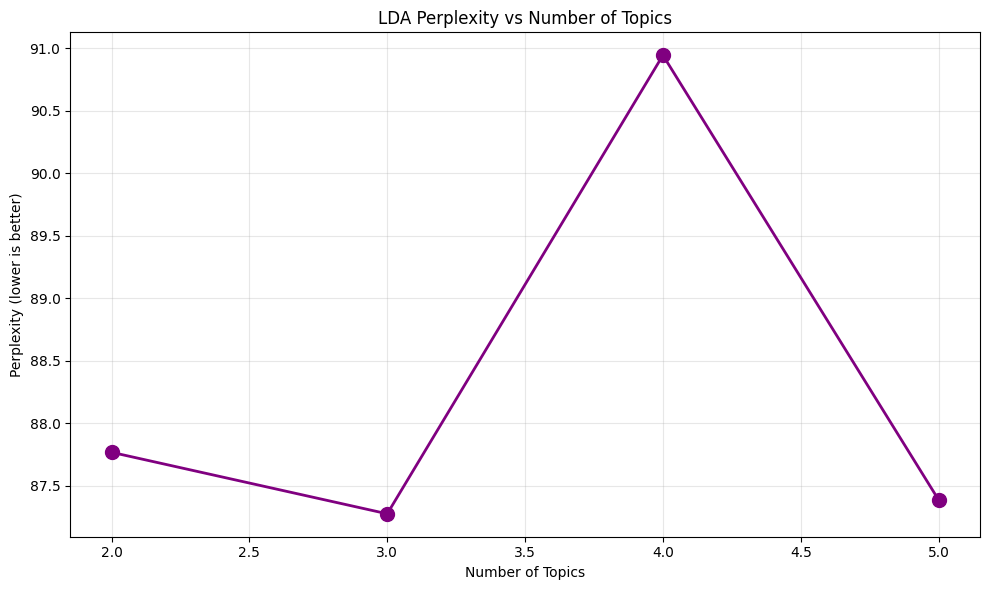

✓ Saved: lda_perplexity.png


In [ ]:
# ============================================================================
# POINT 4: LATENT DIRICHLET ALLOCATION (LDA)
# ============================================================================

from sklearn.decomposition import LatentDirichletAllocation

print("\n" + "=" * 80)
print("POINT 4: LATENT DIRICHLET ALLOCATION (LDA)")
print("=" * 80)

# LDA works with count data (BoW), not TF-IDF
lda_results = {}

for n_components in n_components_list:
    print(f"\n{'='*80}")
    print(f"LDA WITH {n_components} TOPICS")
    print(f"{'='*80}")

    print(f"\nTraining LDA with {n_components} topics...")

    lda_model = LatentDirichletAllocation(
        n_components=n_components,
        random_state=42,
        max_iter=50,
        learning_method='batch'
    )

    lda_topics = lda_model.fit_transform(bow_matrix)

    print(f"Original BoW shape: {bow_matrix.shape}")
    print(f"LDA topics shape: {lda_topics.shape}")
    print(f"Log-likelihood: {lda_model.score(bow_matrix):.2f}")
    print(f"Perplexity: {lda_model.perplexity(bow_matrix):.2f} (lower is better)")

    # Show top words for each topic
    print(f"\n--- Top 10 words per LDA topic ---")
    bow_terms = bow_vectorizer.get_feature_names_out()

    for topic_idx, topic in enumerate(lda_model.components_):
        top_indices = topic.argsort()[-10:][::-1]
        top_words = [bow_terms[idx] for idx in top_indices]
        top_weights = [topic[idx] for idx in top_indices]

        print(f"\nTopic {topic_idx + 1}:")
        for word, weight in zip(top_words, top_weights):
            print(f"  {word:20s} {weight:.4f}")

    # Show document-topic distributions
    print(f"\n--- Document Topic Distributions (Probabilities) ---")
    for i, (doc, dist) in enumerate(zip(documents, lda_topics)):
        dominant_topic = dist.argmax() + 1
        confidence = dist.max()
        print(f"Doc {i+1} ({doc['topic'][:25]:25s}): ", end="")
        for topic_idx, prob in enumerate(dist):
            print(f"T{topic_idx+1}={prob:.2f} ", end="")
        print(f"→ Dominant: T{dominant_topic} ({confidence:.1%})")

    # Store results
    lda_results[n_components] = {
        'model': lda_model,
        'topics': lda_topics,
        'perplexity': lda_model.perplexity(bow_matrix),
        'log_likelihood': lda_model.score(bow_matrix)
    }

    # Visualizations
    if n_components >= 2:
        # 2D scatter plot
        fig, ax = plt.subplots(figsize=(10, 8))
        colors = ['red', 'blue', 'green']
        topic_labels = [doc['topic'] for doc in documents]
        unique_topics = list(set(topic_labels))

        for i, topic_label in enumerate(unique_topics):
            indices = [j for j, t in enumerate(topic_labels) if t == topic_label]
            ax.scatter(lda_topics[indices, 0], lda_topics[indices, 1],
                      c=colors[i], label=topic_label[:30], s=150, alpha=0.6)
            for idx in indices:
                ax.annotate(f'D{idx+1}',
                          (lda_topics[idx, 0], lda_topics[idx, 1]),
                          fontsize=8, ha='center')

        ax.set_xlabel('Topic 1 Probability')
        ax.set_ylabel('Topic 2 Probability')
        ax.set_title(f'LDA Topic Space ({n_components} topics)')
        ax.legend()
        ax.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig(f'lda_2d_{n_components}topics.png', dpi=300)
        plt.show()
        print(f"✓ Saved: lda_2d_{n_components}topics.png")

    # Topic distribution bar chart
    fig, ax = plt.subplots(figsize=(14, 6))
    x = np.arange(15)
    width = 0.8 / n_components

    for topic_idx in range(n_components):
        ax.bar(x + topic_idx * width,
               lda_topics[:, topic_idx],
               width,
               label=f'Topic {topic_idx + 1}')

    ax.set_xlabel('Documents')
    ax.set_ylabel('Topic Probability')
    ax.set_title(f'LDA Topic Distribution ({n_components} topics)')
    ax.set_xticks(x + width * (n_components - 1) / 2)
    ax.set_xticklabels([f'D{i+1}' for i in range(15)])
    ax.legend()
    ax.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.savefig(f'lda_distribution_{n_components}topics.png', dpi=300)
    plt.show()
    print(f"✓ Saved: lda_distribution_{n_components}topics.png")

# Compare perplexity scores
print(f"\n--- LDA Perplexity Comparison ---")
for n_comp, results in lda_results.items():
    print(f"{n_comp} topics: {results['perplexity']:.2f} (lower is better)")

plt.figure(figsize=(10, 6))
plt.plot(list(lda_results.keys()),
         [r['perplexity'] for r in lda_results.values()],
         marker='o', linewidth=2, markersize=10, color='purple')
plt.xlabel('Number of Topics')
plt.ylabel('Perplexity (lower is better)')
plt.title('LDA Perplexity vs Number of Topics')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('lda_perplexity.png', dpi=300)
plt.show()
print(f"✓ Saved: lda_perplexity.png")



POINT 5: EVALUATION METRICS FROM GENSIM LIBRARY

Preparing data for Gensim evaluation...
✓ Dictionary size: 691
✓ Corpus size: 15

COMPUTING COHERENCE SCORES

--- Evaluating 2 topics ---
  Training Gensim LDA...
  Computing coherence scores...
  ✓ Gensim LDA Coherence (C_v): 0.4826
  ✓ LSA Coherence (C_v): 0.5572
  ✓ LSA BOW Coherence (C_v): 0.6993
  ✓ NMF Coherence (C_v): 0.6246
  ✓ sklearn LDA Coherence (C_v): 0.3559

--- Evaluating 3 topics ---
  Training Gensim LDA...
  Computing coherence scores...
  ✓ Gensim LDA Coherence (C_v): 0.4986
  ✓ LSA Coherence (C_v): 0.4773
  ✓ LSA BOW Coherence (C_v): 0.6666
  ✓ NMF Coherence (C_v): 0.5762
  ✓ sklearn LDA Coherence (C_v): 0.4331

--- Evaluating 4 topics ---
  Training Gensim LDA...
  Computing coherence scores...
  ✓ Gensim LDA Coherence (C_v): 0.4278
  ✓ LSA Coherence (C_v): 0.4911
  ✓ LSA BOW Coherence (C_v): 0.7023
  ✓ NMF Coherence (C_v): 0.6064
  ✓ sklearn LDA Coherence (C_v): 0.3222

--- Evaluating 5 topics ---
  Training Gensim

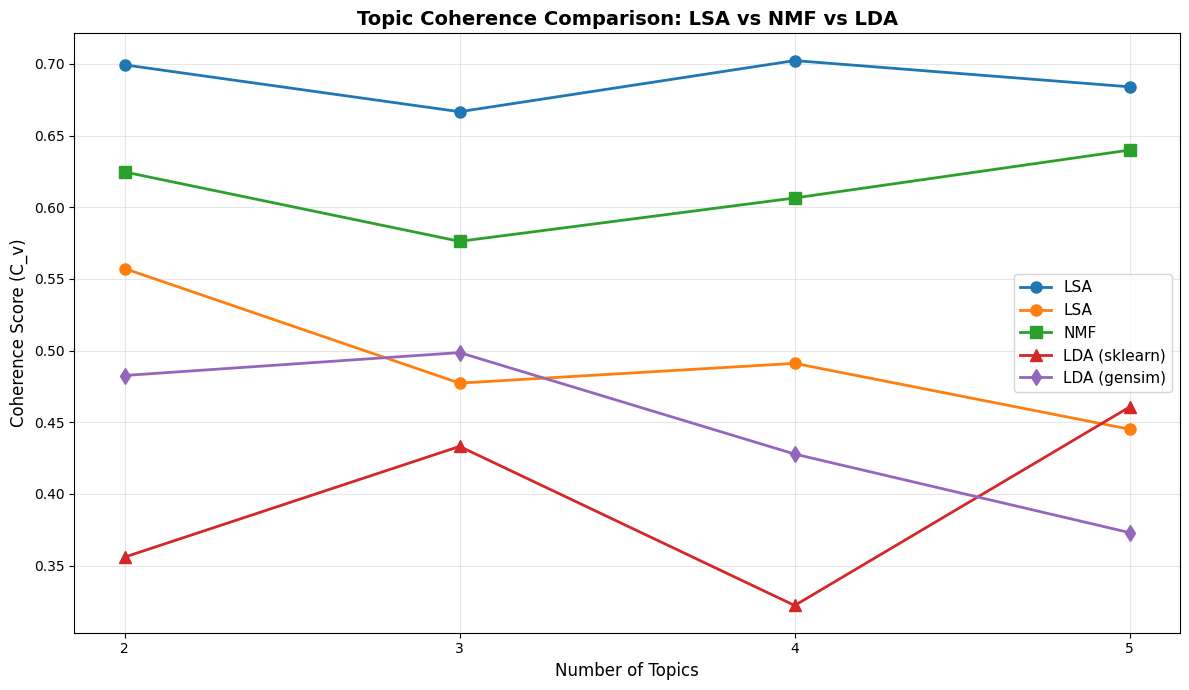


✓ Saved: coherence_comparison_all_models.png

BEST MODEL ANALYSIS

2 topics: LSA BOW wins with coherence 0.6993

3 topics: LSA BOW wins with coherence 0.6666

4 topics: LSA BOW wins with coherence 0.7023

5 topics: LSA BOW wins with coherence 0.6839

ALL EVALUATIONS COMPLETE!


In [ ]:
# ============================================================================
# POINT 5: EVALUATION METRICS FROM GENSIM
# ============================================================================

print("\n" + "=" * 80)
print("POINT 5: EVALUATION METRICS FROM GENSIM LIBRARY")
print("=" * 80)

# Install gensim if needed
try:
    import gensim
    from gensim import corpora
    from gensim.models import LdaModel, CoherenceModel
except ImportError:
    print("Installing gensim...")
    import subprocess
    import sys
    subprocess.check_call([sys.executable, "-m", "pip", "install", "gensim"])
    import gensim
    from gensim import corpora
    from gensim.models import LdaModel, CoherenceModel

# Prepare data for Gensim
print("\nPreparing data for Gensim evaluation...")
tokenized_docs = [doc.split() for doc in processed_texts]
dictionary = corpora.Dictionary(tokenized_docs)
corpus = [dictionary.doc2bow(doc) for doc in tokenized_docs]

print(f"✓ Dictionary size: {len(dictionary)}")
print(f"✓ Corpus size: {len(corpus)}")

# Evaluate models with different numbers of topics
print("\n" + "="*80)
print("COMPUTING COHERENCE SCORES")
print("="*80)

coherence_scores = {
    'lsa_tfidf': {},
    'lsa_bow': {},
    'nmf': {},
    'lda_sklearn': {},
    'lda_gensim': {}
}

for n_topics in [2, 3, 4, 5]:
    print(f"\n--- Evaluating {n_topics} topics ---")

    # 1. Train Gensim LDA (for comparison)
    print(f"  Training Gensim LDA...")
    lda_gensim = LdaModel(
        corpus=corpus,
        id2word=dictionary,
        num_topics=n_topics,
        random_state=42,
        passes=10
    )

    # 2. Compute Coherence Score (C_v) - most common metric
    print(f"  Computing coherence scores...")

    # For Gensim LDA
    coherence_model = CoherenceModel(
        model=lda_gensim,
        texts=tokenized_docs,
        dictionary=dictionary,
        coherence='c_v'
    )
    coherence_gensim = coherence_model.get_coherence()
    coherence_scores['lda_gensim'][n_topics] = coherence_gensim
    print(f"  ✓ Gensim LDA Coherence (C_v): {coherence_gensim:.4f}")

    # For sklearn models, we need to extract top words
    # LSA - tf idf
    svd_temp = TruncatedSVD(n_components=n_topics, random_state=42)
    svd_temp.fit(tfidf_matrix)
    lsa_topics = []
    for topic in svd_temp.components_:
        top_indices = topic.argsort()[-10:][::-1]
        top_words = [tfidf_vectorizer.get_feature_names_out()[i] for i in top_indices]
        lsa_topics.append(top_words)

    coherence_lsa = CoherenceModel(
        topics=lsa_topics,
        texts=tokenized_docs,
        dictionary=dictionary,
        coherence='c_v'
    )
    coherence_scores['lsa_tfidf'][n_topics] = coherence_lsa.get_coherence()
    print(f"  ✓ LSA Coherence (C_v): {coherence_scores['lsa_tfidf'][n_topics]:.4f}")

    # For sklearn models, we need to extract top words
    # LSA - bow
    svd_temp = TruncatedSVD(n_components=n_topics, random_state=42)
    svd_temp.fit(bow_matrix)
    lsa_topics = []
    for topic in svd_temp.components_:
        top_indices = topic.argsort()[-10:][::-1]
        top_words = [tfidf_vectorizer.get_feature_names_out()[i] for i in top_indices]
        lsa_topics.append(top_words)

    coherence_lsa = CoherenceModel(
        topics=lsa_topics,
        texts=tokenized_docs,
        dictionary=dictionary,
        coherence='c_v'
    )
    coherence_scores['lsa_bow'][n_topics] = coherence_lsa.get_coherence()
    print(f"  ✓ LSA BOW Coherence (C_v): {coherence_scores['lsa_bow'][n_topics]:.4f}")

    # NMF
    nmf_temp = NMF(n_components=n_topics, random_state=42, max_iter=500)
    nmf_temp.fit(tfidf_matrix)
    nmf_topics = []
    for topic in nmf_temp.components_:
        top_indices = topic.argsort()[-10:][::-1]
        top_words = [tfidf_vectorizer.get_feature_names_out()[i] for i in top_indices]
        nmf_topics.append(top_words)

    coherence_nmf = CoherenceModel(
        topics=nmf_topics,
        texts=tokenized_docs,
        dictionary=dictionary,
        coherence='c_v'
    )
    coherence_scores['nmf'][n_topics] = coherence_nmf.get_coherence()
    print(f"  ✓ NMF Coherence (C_v): {coherence_scores['nmf'][n_topics]:.4f}")

    # sklearn LDA
    lda_temp = LatentDirichletAllocation(n_components=n_topics, random_state=42, max_iter=50)
    lda_temp.fit(bow_matrix)
    lda_sklearn_topics = []
    for topic in lda_temp.components_:
        top_indices = topic.argsort()[-10:][::-1]
        top_words = [bow_vectorizer.get_feature_names_out()[i] for i in top_indices]
        lda_sklearn_topics.append(top_words)

    coherence_lda_sklearn = CoherenceModel(
        topics=lda_sklearn_topics,
        texts=tokenized_docs,
        dictionary=dictionary,
        coherence='c_v'
    )
    coherence_scores['lda_sklearn'][n_topics] = coherence_lda_sklearn.get_coherence()
    print(f"  ✓ sklearn LDA Coherence (C_v): {coherence_scores['lda_sklearn'][n_topics]:.4f}")

# Summary comparison
print("\n" + "="*80)
print("COHERENCE SCORE SUMMARY (higher is better)")
print("="*80)
print(f"\n{'Topics':<10} {'LSA':<12} {'NMF':<12} {'LDA (sklearn)':<15} {'LDA (gensim)':<15}")
print("-" * 65)
for n_topics in [2, 3, 4, 5]:
    print(f"{n_topics:<10} "
          f"{coherence_scores['lsa_bow'][n_topics]:<12.4f} "
           f"{coherence_scores['lsa_tfidf'][n_topics]:<12.4f} "
          f"{coherence_scores['nmf'][n_topics]:<12.4f} "
          f"{coherence_scores['lda_sklearn'][n_topics]:<15.4f} "
          f"{coherence_scores['lda_gensim'][n_topics]:<15.4f}")

# Visualization: Coherence comparison
fig, ax = plt.subplots(figsize=(12, 7))

topics_range = [2, 3, 4, 5]
ax.plot(topics_range, [coherence_scores['lsa_bow'][n] for n in topics_range],
        marker='o', label='LSA', linewidth=2, markersize=8),
ax.plot(topics_range, [coherence_scores['lsa_tfidf'][n] for n in topics_range],
        marker='o', label='LSA', linewidth=2, markersize=8)
ax.plot(topics_range, [coherence_scores['nmf'][n] for n in topics_range],
        marker='s', label='NMF', linewidth=2, markersize=8)
ax.plot(topics_range, [coherence_scores['lda_sklearn'][n] for n in topics_range],
        marker='^', label='LDA (sklearn)', linewidth=2, markersize=8)
ax.plot(topics_range, [coherence_scores['lda_gensim'][n] for n in topics_range],
        marker='d', label='LDA (gensim)', linewidth=2, markersize=8)

ax.set_xlabel('Number of Topics', fontsize=12)
ax.set_ylabel('Coherence Score (C_v)', fontsize=12)
ax.set_title('Topic Coherence Comparison: LSA vs NMF vs LDA', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
ax.set_xticks(topics_range)
plt.tight_layout()
plt.savefig('coherence_comparison_all_models.png', dpi=300)
plt.show()
print(f"\n✓ Saved: coherence_comparison_all_models.png")

# Best model determination
print("\n" + "="*80)
print("BEST MODEL ANALYSIS")
print("="*80)

for n_topics in [2, 3, 4, 5]:
    scores = {
        'LSA BOW': coherence_scores['lsa_bow'][n_topics],
        'LSA TFIDF': coherence_scores['lsa_tfidf'][n_topics],
        'NMF': coherence_scores['nmf'][n_topics],
        'LDA (sklearn)': coherence_scores['lda_sklearn'][n_topics],
        'LDA (gensim)': coherence_scores['lda_gensim'][n_topics]
    }
    best_model = max(scores, key=scores.get)
    best_score = scores[best_model]
    print(f"\n{n_topics} topics: {best_model} wins with coherence {best_score:.4f}")

print("\n" + "="*80)
print("ALL EVALUATIONS COMPLETE!")
print("="*80)

In [ ]:
!pip install gensim pyLDAvis --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 79.4 MB/s eta 0:00:00


In [ ]:
# ============================================================================
# POINT 6: VISUALIZATION FOR THE BEST MODEL (PER TOPIC COUNT)
# ============================================================================

print("\n" + "=" * 80)
print("POINT 6: VISUALIZATION FOR BEST MODEL PER TOPIC COUNT")
print("=" * 80)

try:
    import pyLDAvis
    import pyLDAvis.gensim_models as gensimvis
except ImportError:
    print("Installing pyLDAvis...")
    import subprocess, sys
    subprocess.check_call([sys.executable, "-m", "pip", "install", "pyLDAvis"])
    import pyLDAvis
    import pyLDAvis.gensim_models as gensimvis

pyLDAvis.enable_notebook()

# Helper function for sklearn-like models (LSA, NMF, sklearn LDA)
def visualize_sklearn_model(model, doc_term_matrix, vectorizer, model_name, n_topics):
    """Generic visualization for sklearn models using pyLDAvis.prepare()"""
    try:
        import numpy as np

        topic_term_dists = np.maximum(model.components_, 1e-12)
        topic_term_dists /= topic_term_dists.sum(axis=1)[:, None]

        doc_topic_dists = model.transform(doc_term_matrix)
        doc_topic_dists = doc_topic_dists / (doc_topic_dists.sum(axis=1, keepdims=True) + 1e-12)

        doc_lengths = np.array(doc_term_matrix.sum(axis=1)).flatten()
        term_frequency = np.array(doc_term_matrix.sum(axis=0)).flatten()
        vocab = vectorizer.get_feature_names_out()

        vis_data = pyLDAvis.prepare(
            topic_term_dists=topic_term_dists,
            doc_topic_dists=doc_topic_dists,
            doc_lengths=doc_lengths,
            vocab=vocab,
            term_frequency=term_frequency
        )
        display(vis_data)
        pyLDAvis.save_html(vis_data, f"pyLDAvis_best_{model_name}_{n_topics}.html")
        print(f"✓ Displayed and saved: pyLDAvis_best_{model_name}_{n_topics}.html")

    except Exception as e:
        print(f"⚠️ Skipped visualization for {model_name} ({n_topics} topics): {e}")



# Iterate over each topic count and visualize only the best model
for n_topics in [2, 3, 4, 5]:
    scores = {
        'LSA BOW': coherence_scores['lsa_bow'][n_topics],
        'LSA TFIDF': coherence_scores['lsa_tfidf'][n_topics],
        'NMF': coherence_scores['nmf'][n_topics],
        'LDA (sklearn)': coherence_scores['lda_sklearn'][n_topics],
        'LDA (gensim)': coherence_scores['lda_gensim'][n_topics]
    }
    best_model = max(scores, key=scores.get)
    print(f"\n=== {n_topics} TOPICS: BEST MODEL → {best_model} (Coherence = {scores[best_model]:.4f}) ===")

    try:
        if best_model == 'LSA BOW':
            print("🔹 Visualizing LSA...")
            svd_best = TruncatedSVD(n_components=n_topics, random_state=42)
            svd_best.fit(bow_matrix)
            visualize_sklearn_model(svd_best, tfidf_matrix, tfidf_vectorizer, "LSA BOW", n_topics)
        elif best_model == 'LSA TFIDF':
          print("🔹 Visualizing LSA...")
          svd_best = TruncatedSVD(n_components=n_topics, random_state=42)
          svd_best.fit(tfidf_matrix)
          visualize_sklearn_model(svd_best, tfidf_matrix, tfidf_vectorizer, "LSA TFIDF", n_topics)

        elif best_model == 'NMF':
            print("🔹 Visualizing NMF...")
            nmf_best = NMF(n_components=n_topics, random_state=42, max_iter=500)
            nmf_best.fit(tfidf_matrix)
            visualize_sklearn_model(nmf_best, tfidf_matrix, tfidf_vectorizer, "NMF", n_topics)

        elif best_model == 'LDA (sklearn)':
            print("🔹 Visualizing sklearn LDA...")
            lda_best_sklearn = LatentDirichletAllocation(
                n_components=n_topics, random_state=42, max_iter=50, learning_method='batch'
            )
            lda_best_sklearn.fit(bow_matrix)
            visualize_sklearn_model(lda_best_sklearn, bow_matrix, bow_vectorizer, "LDA_sklearn", n_topics)

        elif best_model == 'LDA (gensim)':
            print("🔹 Visualizing gensim LDA...")
            lda_best_gensim = LdaModel(
                corpus=corpus,
                id2word=dictionary,
                num_topics=n_topics,
                random_state=42,
                passes=15,
                iterations=300
            )
            vis = gensimvis.prepare(lda_best_gensim, corpus, dictionary)
            display(vis)
            pyLDAvis.save_html(vis, f"pyLDAvis_best_LDA_gensim_{n_topics}.html")
            print(f"✓ Displayed and saved: pyLDAvis_best_LDA_gensim_{n_topics}.html")

    except Exception as e:
        print(f"⚠️ Error generating visualization for {best_model} ({n_topics} topics): {e}")

print("\n✅ All best models per topic count visualized inline and saved locally.")


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag


POINT 6: VISUALIZATION FOR BEST MODEL PER TOPIC COUNT

=== 2 TOPICS: BEST MODEL → LSA BOW (Coherence = 0.6993) ===
🔹 Visualizing LSA...


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

PreparedData(topic_coordinates=              x    y  topics  cluster       Freq
topic                                           
1      0.192773  0.0       1        1  51.361509
0     -0.192773  0.0       2        1  48.638491, topic_info=            Term      Freq     Total Category  logprob  loglift
79         state  3.000000  3.000000  Default  30.0000  30.0000
41       montana  2.000000  2.000000  Default  29.0000  29.0000
0        adopted  1.000000  1.000000  Default  28.0000  28.0000
30   legislature  0.000000  0.000000  Default  27.0000  27.0000
82       student  2.000000  2.000000  Default  26.0000  26.0000
..           ...       ...       ...      ...      ...      ...
70       several  0.280303  0.503626   Topic2  -4.4583   0.1348
95  united state  0.246675  0.460599   Topic2  -4.5861   0.0963
94        united  0.258975  0.530404   Topic2  -4.5375   0.0038
82       student  0.382851  2.311476   Topic2  -4.1465  -1.0772
64        school  0.255852  0.863482   Topic2  -4.5496  -0.4956

[109 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
0         2  0.794766      adopted
13        1  1.315965      college
15        1  1.395327         dame
20        1  1.607172         dome
28        1  1.186379      journal
30        2  1.180931  legislature
34        1  1.115402     magazine
41        2  1.093352      montana
44        2  1.697782     mountain
47        1  1.497306         news
48        1  1.045658    newspaper
50        1  1.395327        notre
51        1  1.395327   notre dame
53        1  0.889784     observer
55        1  1.186379        paper
57        2  1.747801   population
58        1  1.682089      program
59        1  1.186379  publication
60        1  0.889784    published
64        1  1.158102       school
76        2  1.292501         song
79        2  1.004323        state
82        1  0.865248      student
86        2  1.810513           th
87        1  1.480674        three
96        1  1.063237   university
99        1  1.000273         year, R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1])

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

✓ Displayed and saved: pyLDAvis_best_LSA BOW_2.html

=== 3 TOPICS: BEST MODEL → LSA BOW (Coherence = 0.6666) ===
🔹 Visualizing LSA...


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.246520  0.047492       1        1  42.416044
1     -0.066292 -0.177879       2        1  34.381475
2     -0.180229  0.130387       3        1  23.202481, topic_info=       Term      Freq     Total Category  logprob  loglift
79    state  3.000000  3.000000  Default  30.0000  30.0000
41  montana  2.000000  2.000000  Default  29.0000  29.0000
7    beyonc  1.000000  1.000000  Default  28.0000  28.0000
0   adopted  1.000000  1.000000  Default  27.0000  27.0000
82  student  1.000000  1.000000  Default  26.0000  26.0000
..      ...       ...       ...      ...      ...      ...
69    seven  0.108090  0.260459   Topic3  -4.6711   0.5814
76     song  0.437749  1.072709   Topic3  -3.2724   0.5646
99     year  0.402492  1.116624   Topic3  -3.3564   0.4405
54      one  0.281356  0.774867   Topic3  -3.7144   0.4478
58  program  0.169772  0.581399   Topic3  -4.2196   0.2299

[139 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
0         1  0.911357      adopted
4         3  1.188609       artist
7         3  0.688144       beyonc
28        2  1.715365      journal
30        1  1.354172  legislature
34        2  1.610356     magazine
41        1  0.835831      montana
44        1  1.946851     mountain
48        2  1.469068    newspaper
53        2  1.286524     observer
55        2  1.715365        paper
59        2  1.715365  publication
60        2  1.286524    published
64        3  0.713741       school
76        1  0.932219         song
79        1  0.863743        state
82        2  0.615426      student
96        2  1.539589   university
99        2  0.895556         year, R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3])

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

✓ Displayed and saved: pyLDAvis_best_LSA BOW_3.html

=== 4 TOPICS: BEST MODEL → LSA BOW (Coherence = 0.7023) ===
🔹 Visualizing LSA...


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.097165  0.255664       1        1  42.261365
1      0.060291 -0.067904       2        1  37.200640
2      0.179523 -0.162669       3        1  25.290226
3     -0.336979 -0.025091       4        1  -4.752231, topic_info=           Term      Freq     Total Category  logprob  loglift
79        state  3.000000  3.000000  Default  30.0000  30.0000
41      montana  2.000000  2.000000  Default  29.0000  29.0000
7        beyonc  1.000000  1.000000  Default  28.0000  28.0000
82      student  1.000000  1.000000  Default  27.0000  27.0000
30  legislature  0.000000  0.000000  Default  26.0000  26.0000
..          ...       ...       ...      ...      ...      ...
41      montana -0.040899  2.343202   Topic4  -4.0573  -1.0016
25         gold -0.001768  0.146003   Topic4  -7.1987  -1.3674
61        range -0.003360  0.277979   Topic4  -6.5565  -1.3691
69        seven -0.002480  0.268638   Topic4  -6.8600  -1.6384
8      building -0.001404  0.157792   Topic4  -7.4292  -1.6755

[168 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
0         1  0.951216      adopted
4         3  1.099076       artist
7         3  0.636087       beyonc
13        2  4.073894      college
28        2  1.602919      journal
30        1  1.359129  legislature
34        2  1.505543     magazine
41        1  0.853533      montana
44        1  1.991834     mountain
48        2  1.385842    newspaper
53        2  1.202189     observer
55        2  1.602919        paper
59        2  1.602919  publication
60        2  1.202189    published
64        3  0.665343       school
76        1  0.892034         song
79        1  0.866905        state
82        2  0.578193      student
96        2  1.437961   university
99        2  0.884128         year, R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4])

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

✓ Displayed and saved: pyLDAvis_best_LSA BOW_4.html

=== 5 TOPICS: BEST MODEL → LSA BOW (Coherence = 0.6839) ===
🔹 Visualizing LSA...


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.048596 -0.195605       1        1  44.203699
1      0.048754 -0.001056       2        1  41.505337
2      0.142921 -0.094912       3        1  40.136934
3     -0.354010  0.021467       4        1 -11.279135
4      0.113738  0.270107       5        1 -14.566836, topic_info=           Term      Freq     Total Category  logprob  loglift
79        state  3.000000  3.000000  Default  30.0000  30.0000
41      montana  2.000000  2.000000  Default  29.0000  29.0000
82      student  1.000000  1.000000  Default  28.0000  28.0000
30  legislature  0.000000  0.000000  Default  27.0000  27.0000
53     observer  0.000000  0.000000  Default  26.0000  26.0000
..          ...       ...       ...      ...      ...      ...
99         year -0.087432  1.287613   Topic5  -4.4177  -0.7633
84       symbol -0.019392  0.378585   Topic5  -5.9237  -1.0452
12         city -0.010871  0.249709   Topic5  -6.5024  -1.2078
7        beyonc -0.084038  2.194386   Topic5  -4.4572  -1.3360
41      montana -0.053387  2.343216   Topic5  -4.9110  -1.8553

[205 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
0         1  1.037142      adopted
1         3  1.520835        album
2         3  0.788931         also
4         3  0.761811       artist
5         3  1.508910        award
7         3  0.911417       beyonc
11        3  1.178282        child
15        2  1.915311         dame
28        2  1.448331      journal
29        3  1.537534      knowles
30        1  1.304714  legislature
34        2  1.360846     magazine
41        1  0.853528      montana
44        1  1.952319     mountain
45        3  1.018343        music
48        2  1.261097    newspaper
50        2  1.915311        notre
51        2  1.915311   notre dame
53        2  1.086248     observer
55        2  1.448331        paper
57        1  2.480758   population
59        2  1.448331  publication
60        2  1.086248    published
64        3  0.772115       school
76        1  0.694134         song
76        3  0.694134         song
79        1  1.105083        state
82        2  1.049066      student
86        1  2.165911           th
96        2  1.489047   university
99        2  0.776631         year
99        3  0.776631         year, R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5])

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

✓ Displayed and saved: pyLDAvis_best_LSA BOW_5.html

✅ All best models per topic count visualized inline and saved locally.


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag


POINT 6: VISUALIZATION OF DOCUMENT VECTORS AND COSINE RELATIONSHIPS
Selected for visualization: LSA_BOW (4 topics, C_v=0.7023)


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

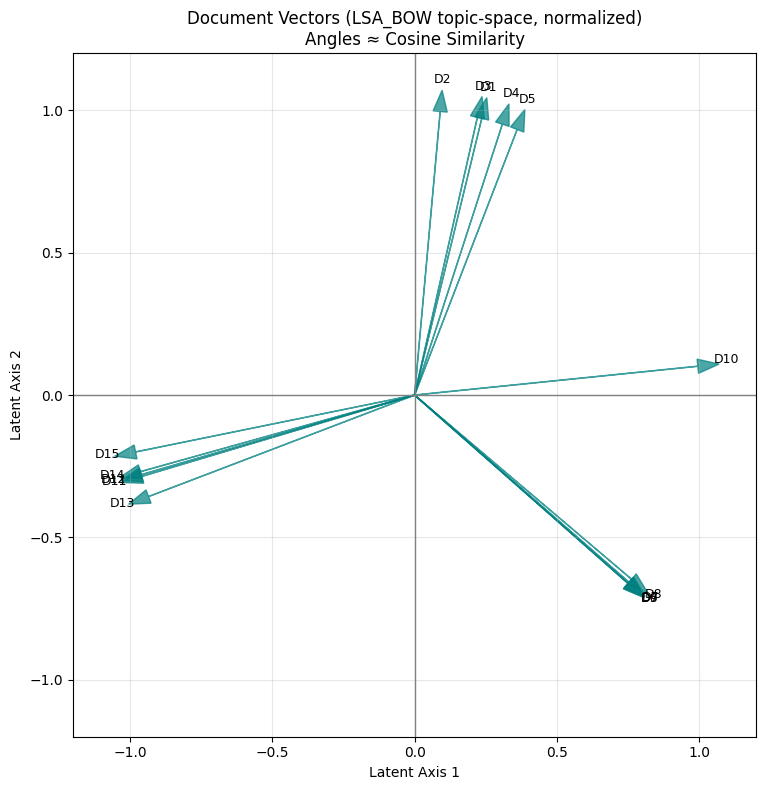

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

✓ Saved: lsa_bow_vector_angles.png


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


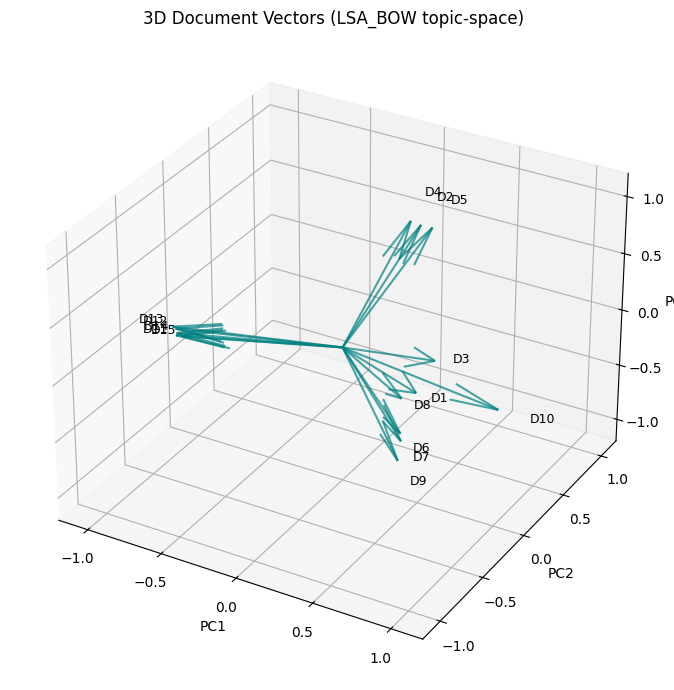

✓ 3D vector plot generated successfully.

✅ POINT 6 COMPLETE - COSINE RELATIONSHIP VISUALIZATION DONE.


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

In [ ]:
# ============================================================================
# POINT 6: VISUALIZATION OF DOCUMENT VECTORS AND COSINE RELATIONSHIPS
# ============================================================================

print("\n" + "=" * 80)
print("POINT 6: VISUALIZATION OF DOCUMENT VECTORS AND COSINE RELATIONSHIPS")
print("=" * 80)

import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
import numpy as np


best_model_name, best_n, best_score = None, None, -1
for model_name, results in coherence_scores.items():
    for n, score in results.items():
        if score > best_score:
            best_model_name, best_n, best_score = model_name, n, score

print(f"Selected for visualization: {best_model_name.upper()} ({best_n} topics, C_v={best_score:.4f})")


if "nmf" in best_model_name:
    topic_vectors = nmf_results[max(nmf_results.keys())]['topics']
elif "lsa" in best_model_name:
    topic_vectors = tfidf_lsa
elif "lda_sklearn" in best_model_name:
    topic_vectors = lda_results[max(lda_results.keys())]['topics']
else:
    topic_vectors = nmf_results[max(nmf_results.keys())]['topics']  # fallback


pca = PCA(n_components=2)
reduced = pca.fit_transform(topic_vectors)


norms = np.linalg.norm(reduced, axis=1, keepdims=True)
normalized = reduced / norms


plt.figure(figsize=(8, 8))
plt.axhline(0, color='gray', lw=1)
plt.axvline(0, color='gray', lw=1)

for i, vec in enumerate(normalized):
    plt.arrow(0, 0, vec[0], vec[1], head_width=0.05, color='teal', alpha=0.7)
    plt.text(vec[0]*1.1, vec[1]*1.1, f"D{i+1}", fontsize=9, ha='center')

plt.xlim(-1.2, 1.2)
plt.ylim(-1.2, 1.2)
plt.xlabel("Latent Axis 1")
plt.ylabel("Latent Axis 2")
plt.title(f"Document Vectors ({best_model_name.upper()} topic-space, normalized)\nAngles ≈ Cosine Similarity")
plt.grid(alpha=0.3)
plt.gca().set_aspect('equal', 'box')
plt.tight_layout()
plt.savefig(f"{best_model_name}_vector_angles.png", dpi=300)
plt.show()

print(f"✓ Saved: {best_model_name}_vector_angles.png")


try:
    from mpl_toolkits.mplot3d import Axes3D

    pca3 = PCA(n_components=3)
    reduced3 = pca3.fit_transform(topic_vectors)
    norms3 = np.linalg.norm(reduced3, axis=1, keepdims=True)
    normalized3 = reduced3 / norms3

    fig = plt.figure(figsize=(9, 7))
    ax = fig.add_subplot(111, projection='3d')

    for i, vec in enumerate(normalized3):
        ax.quiver(0, 0, 0, vec[0], vec[1], vec[2], color='teal', alpha=0.7)
        ax.text(vec[0]*1.2, vec[1]*1.2, vec[2]*1.2, f"D{i+1}", fontsize=9)

    ax.set_xlim([-1.2, 1.2])
    ax.set_ylim([-1.2, 1.2])
    ax.set_zlim([-1.2, 1.2])
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
    ax.set_zlabel("PC3")
    ax.set_title(f"3D Document Vectors ({best_model_name.upper()} topic-space)")
    plt.tight_layout()
    plt.show()

    print(f"✓ 3D vector plot generated successfully.")

except Exception as e:
    print(f"⚠️ Skipped 3D visualization due to: {e}")

print("\n✅ POINT 6 COMPLETE - COSINE RELATIONSHIP VISUALIZATION DONE.")


In [ ]:
# O varianță mai mare nu garanteaza neaparat o coerență mai mare, am încercat și cu >10 topic-uri, obținusem o varianță foarte mare (>95%), însă topic-urile rezultate erau overlapping și nu puteau fi interpretate intuitiv, precum se poate face în cazul cu 2-3-4-5 topic-uri.
# In cazul LSA_BOW, LSA_TFIDF, NMF, heat-map-urile pentru 3 topic-uri castiga in fata celorlalte din aceeasi categorie, intrucat cosine_similarity este mare (>0.8) in mod intuitiv, acolo unde ar trebui sa fie.  Se observa ca LSA_BOW are o coerenta mai mare decat toti agloritmii.
# Scatter plot-urile pentru varianță se aseamana intre ele indiferent de numarul de topicuri intrucat primele 2 topic-uri domina celelalte topic-uri.